In [1]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# XGBoost 및 머신러닝 라이브러리
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import pickle
import os

# Optuna 하이퍼파라미터 최적화 라이브러리
import optuna
from optuna.samplers import TPESampler

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Optuna 로깅 레벨 설정 (경고 메시지 줄이기)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# DACON 1위 솔루션에서 사용한 평가 함수들
def smape(y_true, y_pred):
    """
    SMAPE (Symmetric Mean Absolute Percentage Error) 계산
    DACON 전력 사용량 예측 대회의 평가 지표
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # 0/0 방지
    return np.mean(diff) * 100

def calculate_metrics(y_true, y_pred):
    """
    다양한 평가 지표 계산
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape_score = smape(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'SMAPE': smape_score,
        'MAPE': mape
    }

print("🚀 개별 건물 모델링 with XGBoost + Optuna 시작!")
print("=" * 50)


🚀 개별 건물 모델링 with XGBoost + Optuna 시작!


In [2]:
# 데이터 로드
print("📊 데이터 로드 중...")
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
building_info = pd.read_csv('data/building_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print(f"✅ Train 데이터: {train_df.shape}")
print(f"✅ Test 데이터: {test_df.shape}")
print(f"✅ Building info: {building_info.shape}")
print(f"✅ 총 건물 수: {len(building_info)}")

# 데이터 미리보기
display(train_df.head())
display(building_info.head())


📊 데이터 로드 중...
✅ Train 데이터: (204000, 10)
✅ Test 데이터: (16800, 7)
✅ Building info: (100, 7)
✅ 총 건물 수: 100


,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20240601 00,1,20240601 00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80
1,1_20240601 01,1,20240601 01,18.3,0.0,2.7,82.0,0.0,0.0,5591.85
2,1_20240601 02,1,20240601 02,18.1,0.0,2.6,80.0,0.0,0.0,5338.17
3,1_20240601 03,1,20240601 03,18.0,0.0,2.6,81.0,0.0,0.0,4554.42
4,1_20240601 04,1,20240601 04,17.8,0.0,1.3,81.0,0.0,0.0,3602.25


,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,호텔,82912.71,77586.00,-,-,-
1,2,상용,40658.90,30392.82,-,-,-
2,3,병원,560431.00,418992.00,278.58,-,-
3,4,호텔,41813.29,23715.71,-,-,-
4,5,학교,403749.39,248507.00,1983.05,1025,250


In [3]:
def calculate_cdh(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)] - 26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)] - 26))
    return np.array(ys)

def create_features(df, building_info):
    """
    Feature Engineering 함수 - 시간, 기상, 건물 관련 피처 생성
    """
    df = df.copy()
    
    # 건물 정보 병합
    building_info_processed = building_info.copy()
    
    # 불필요한 컬럼 제거 (결측치가 많은 컬럼들)
    drop_columns = ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']
    for col in drop_columns:
        if col in building_info_processed.columns:
            building_info_processed = building_info_processed.drop(col, axis=1)
    
    # 건물 정보 병합
    df = df.merge(building_info_processed, on='건물번호', how='left')
    
    # 원본 데이터에서 불필요한 컬럼 제거
    drop_original_columns = ['일조(hr)', '일사(MJ/m2)']
    for col in drop_original_columns:
        if col in df.columns:
            df = df.drop(col, axis=1)
    
    # 날짜/시간 변환
    df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')
    
    # 시간 관련 피처
    df['연도'] = df['일시'].dt.year
    df['월'] = df['일시'].dt.month
    df['일'] = df['일시'].dt.day
    df['시간'] = df['일시'].dt.hour
    df['요일'] = df['일시'].dt.dayofweek
    df['주말여부'] = (df['요일'] >= 5).astype(int)
    
    # CDH (Cooling Degree Hours) - 냉방도시
    df['CDH'] = np.maximum(df['기온(°C)'] - 26, 0)
    
    # THI (Temperature Humidity Index) - 온습도지수
    df['THI'] = 9/5 * df['기온(°C)'] - 0.55 * (1 - df['습도(%)'] / 100) * (9/5 * df['기온(°C)'] - 26) + 32
    
    # 건물 관련 피처
    df['냉방면적_비율'] = df['냉방면적(m2)'] / (df['연면적(m2)'] + 1)
    
    return df

print("\n🔧 Feature Engineering 적용 중...")
train_processed = create_features(train_df, building_info)
test_processed = create_features(test_df, building_info)

print(f"✅ 처리된 train 데이터: {train_processed.shape}")
print(f"✅ 처리된 test 데이터: {test_processed.shape}")

# 생성된 피처 확인
print(f"\n📋 생성된 피처 목록:")
new_features = [col for col in train_processed.columns if col not in train_df.columns]
for i, feature in enumerate(new_features, 1):
    print(f"   {i}. {feature}")



🔧 Feature Engineering 적용 중...
✅ 처리된 train 데이터: (204000, 20)
✅ 처리된 test 데이터: (16800, 19)

📋 생성된 피처 목록:
   1. 건물유형
   2. 연면적(m2)
   3. 냉방면적(m2)
   4. 연도
   5. 월
   6. 일
   7. 시간
   8. 요일
   9. 주말여부
   10. CDH
   11. THI
   12. 냉방면적_비율


In [6]:
# 피처 준비 및 전처리
exclude_columns = ['num_date_time', '일시', '전력소비량(kWh)']
feature_columns = [col for col in train_processed.columns if col not in exclude_columns]

print(f"✅ 사용할 피처 수: {len(feature_columns)}")
print(f"피처 목록: {feature_columns}")

# 카테고리 변수 인코딩
categorical_features = ['건물유형']
label_encoders = {}

for cat_col in categorical_features:
    if cat_col in train_processed.columns:
        le = LabelEncoder()
        # 전체 데이터(train + test)의 카테고리를 기반으로 인코더 학습
        all_categories = pd.concat([train_processed[cat_col], test_processed[cat_col]]).astype(str).unique()
        le.fit(all_categories)
        
        train_processed[cat_col] = le.transform(train_processed[cat_col].astype(str))
        test_processed[cat_col] = le.transform(test_processed[cat_col].astype(str))
        label_encoders[cat_col] = le
        
        print(f"✅ {cat_col} 인코딩 완료: {len(all_categories)}개 카테고리")

# 결측치 처리
train_numeric_columns = train_processed.select_dtypes(include=[np.number]).columns
test_numeric_columns = test_processed.select_dtypes(include=[np.number]).columns

train_processed[train_numeric_columns] = train_processed[train_numeric_columns].fillna(train_processed[train_numeric_columns].mean())
test_processed[test_numeric_columns] = test_processed[test_numeric_columns].fillna(test_processed[test_numeric_columns].mean())

print("✅ 전처리 완료!")


✅ 사용할 피처 수: 17
피처 목록: ['건물번호', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '건물유형', '연면적(m2)', '냉방면적(m2)', '연도', '월', '일', '시간', '요일', '주말여부', 'CDH', 'THI', '냉방면적_비율']
✅ 건물유형 인코딩 완료: 10개 카테고리
✅ 전처리 완료!


In [7]:
print("🏢 Optuna를 활용한 개별 건물 모델 훈련 시작...")
print("=" * 60)
print("🔧 각 건물별로 최적의 하이퍼파라미터를 탐색합니다")
print("⏱️ 시간이 오래 걸릴 수 있습니다 (건물당 2-5분)")
print("=" * 60)

# 모델 저장용 딕셔너리
building_models = {}
building_predictions = {}
building_scores = {}
building_best_params = {}  # 각 건물별 최적 파라미터 저장
building_study_results = {}  # Optuna 스터디 결과 저장

# 각 건물별로 모델 훈련
unique_buildings = sorted(train_processed['건물번호'].unique())
total_buildings = len(unique_buildings)

print(f"총 {total_buildings}개 건물에 대한 개별 최적화 모델 훈련 시작...\n")

# DACON 1위 솔루션에서 사용한 objective 함수와 동일하게 구현
def objective(trial, X, y):
    """
    DACON 1위 솔루션 방식의 Optuna objective 함수
    - 시계열 특성을 고려한 검증 분할 (마지막 2주 = 336시간)
    - RMSE 기반 최적화
    - gamma 파라미터 포함한 XGBoost 전용 최적화
    """
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    # 시계열 데이터 특성을 고려하여 마지막 2주(336시간) 데이터를 검증용으로 사용
    # X와 y는 시간 순서대로 정렬되어 있다고 가정
    n_valid = 24 * 14  # 2주 = 336시간
    X_train, X_valid = X.iloc[:-n_valid], X.iloc[-n_valid:]
    y_train, y_valid = y.iloc[:-n_valid], y.iloc[-n_valid:]
    
    model = xgb.XGBRegressor(**param)
    
    try:
        # early_stopping_rounds 사용
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=20, verbose=False)
    except TypeError:
        # XGBoost 버전 호환성 문제 시 기본 fit 사용
        model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    # DACON 1위 솔루션에서 사용한 평가 함수: RMSE (squared=False)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    return rmse

# DACON 1위 솔루션 방식으로 수정된 create_objective_function
def create_objective_function(X_train, X_val, y_train, y_val):
    """
    DACON 1위 솔루션 방식을 따라 수정된 Optuna 목적 함수 생성
    하지만 이미 분할된 데이터를 사용하는 경우를 위한 wrapper 함수
    """
    def objective_wrapper(trial):
        param = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': 0
        }
        
        model = xgb.XGBRegressor(**param)
        
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=20, verbose=False)
        except TypeError:
            model.fit(X_train, y_train)
        
        preds = model.predict(X_val)
        # DACON 1위 솔루션과 동일한 평가 방식: RMSE
        rmse = mean_squared_error(y_val, preds, squared=False)
        return rmse
    
    return objective_wrapper

optuna_building_params = {}

# for idx, building_num in enumerate(unique_buildings, 1):
#     print(f"\n🔍 Optuna 튜닝: 건물 {building_num} ({idx}/{total_buildings})")
#     train_building = train_processed[train_processed['건물번호'] == building_num].copy()
#     X = train_building[feature_columns]
#     y = train_building['전력소비량(kWh)']
#     study = optuna.create_study(direction='minimize')
#     study.optimize(lambda trial: objective(trial, X, y), n_trials=30, show_progress_bar=False)
#     print(f"   최적 파라미터: {study.best_params}")
#     optuna_building_params[building_num] = study.best_params

# print("✅ 모든 건물에 대한 Optuna 하이퍼파라미터 튜닝 완료!")




🏢 Optuna를 활용한 개별 건물 모델 훈련 시작...
🔧 각 건물별로 최적의 하이퍼파라미터를 탐색합니다
⏱️ 시간이 오래 걸릴 수 있습니다 (건물당 2-5분)
총 100개 건물에 대한 개별 최적화 모델 훈련 시작...



In [8]:
# 건물별 Optuna 최적화 모델 훈련 (처음 3개 건물만 시연)
# 전체 실행 시에는 unique_buildings 전체를 사용하세요

demo_buildings = unique_buildings[:3]  # 시연용으로 처음 3개만 (Optuna는 시간이 오래 걸림)
# demo_buildings = unique_buildings  # 전체 실행 시 이 줄 사용

# Optuna 설정
n_trials = 50  # 시연용으로 50회 시도 (전체 실행 시 100-200으로 증가 권장)
sampler = TPESampler(seed=42)

for idx, building_num in enumerate(demo_buildings, 1):
    print(f"\n🏢 건물 {building_num} Optuna 최적화 중... ({idx}/{len(demo_buildings)})")
    
    # 해당 건물 데이터 필터링
    train_building = train_processed[train_processed['건물번호'] == building_num].copy()
    test_building = test_processed[test_processed['건물번호'] == building_num].copy()
    
    print(f"   📊 훈련 데이터: {len(train_building)}개")
    print(f"   📊 테스트 데이터: {len(test_building)}개")
    
    # 피처와 타겟 분리
    X_building = train_building[feature_columns].copy()
    y_building = train_building['전력소비량(kWh)'].copy()
    X_test_building = test_building[feature_columns].copy()
    
    # 훈련/검증 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(
        X_building, y_building, test_size=0.2, random_state=42
    )
    
    print(f"   🔍 하이퍼파라미터 최적화 시작... ({n_trials}회 시도)")
    
    # Optuna 스터디 생성 및 실행
    study = optuna.create_study(
        direction='minimize',
        sampler=sampler,
        study_name=f'building_{building_num}_optimization'
    )
    
    objective_func = create_objective_function(X_train, X_val, y_train, y_val)
    study.optimize(objective_func, n_trials=n_trials, show_progress_bar=False)
    
    # 최적 파라미터로 최종 모델 훈련
    best_params = study.best_params
    print(f"   🏆 최적 RMSE: {study.best_value:.4f}")
    print(f"   🔧 최적 파라미터: {best_params}")
    
    # 최적 파라미터로 최종 모델 생성
    final_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'verbosity': 0,
        'random_state': 42,
        'n_jobs': -1,
        **best_params
    }
    
    final_model = xgb.XGBRegressor(**final_params)
    
    try:
        final_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=30,
            verbose=False
        )
    except TypeError:
        final_model.fit(X_train, y_train)
    
    # 최종 성능 평가 (DACON 1위 솔루션과 동일한 방식)
    val_pred = final_model.predict(X_val)
    metrics = calculate_metrics(y_val, val_pred)
    
    print(f"   📈 최종 검증 RMSE: {metrics['RMSE']:.2f} kWh")
    print(f"   📈 최종 검증 MAE: {metrics['MAE']:.2f} kWh")
    print(f"   📈 최종 검증 SMAPE: {metrics['SMAPE']:.2f}%")
    print(f"   📈 최종 검증 MAPE: {metrics['MAPE']:.2f}%")
    
    # 테스트 데이터 예측
    test_pred = final_model.predict(X_test_building)
    test_pred = np.maximum(test_pred, 0)  # 음수값 처리
    
    # 결과 저장 (DACON 1위 솔루션과 동일한 평가 지표 포함)
    building_models[building_num] = final_model
    building_predictions[building_num] = test_pred
    building_scores[building_num] = {
        'rmse': metrics['RMSE'], 
        'mae': metrics['MAE'],
        'smape': metrics['SMAPE'],
        'mape': metrics['MAPE']
    }
    building_best_params[building_num] = best_params
    building_study_results[building_num] = {
        'best_value': study.best_value,
        'n_trials': len(study.trials),
        'best_trial': study.best_trial.number
    }

print(f"\n✅ {len(building_models)}개 건물 Optuna 최적화 모델 훈련 완료!")

# 최적화 결과 요약
print(f"\n📊 Optuna 최적화 결과 요약:")
for building_num in building_best_params.keys():
    result = building_study_results[building_num]
    print(f"   건물 {building_num}: 최적 RMSE {result['best_value']:.4f} (Trial #{result['best_trial']})")



🏢 건물 1 Optuna 최적화 중... (1/3)
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🔍 하이퍼파라미터 최적화 시작... (50회 시도)


[W 2025-07-24 17:16:14,543] Trial 16 failed with parameters: {'max_depth': 8, 'learning_rate': 0.04278514033106716, 'subsample': 0.9281889012746769, 'colsample_bytree': 0.9376786002510347, 'n_estimators': 211, 'gamma': 3.6861467608469343, 'min_child_weight': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\minkyu\AppData\Local\Temp\ipykernel_5904\2517265723.py", line 88, in objective_wrapper
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=20, verbose=False)
  File "c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\xgboost\sklearn.py", line 961, in fit
    self._Booster = train(
  File "

KeyboardInterrupt: 

In [11]:
# 전체 성능 통계
all_rmse = [score['rmse'] for score in building_scores.values()]
all_mae = [score['mae'] for score in building_scores.values()]

print("📊 Optuna 최적화 개별 건물 모델 성능 분석")
print("=" * 60)
print(f"🏆 전체 건물 평균 성능:")
print(f"   📈 평균 RMSE: {np.mean(all_rmse):.2f} ± {np.std(all_rmse):.2f} kWh")
print(f"   📈 평균 MAE: {np.mean(all_mae):.2f} ± {np.std(all_mae):.2f} kWh")
print(f"   📈 최고 RMSE: {np.min(all_rmse):.2f} kWh (건물 {min(building_scores.keys(), key=lambda x: building_scores[x]['rmse'])})")
print(f"   📈 최저 RMSE: {np.max(all_rmse):.2f} kWh (건물 {max(building_scores.keys(), key=lambda x: building_scores[x]['rmse'])})")

# 건물별 성능 및 최적 파라미터 DataFrame 생성
performance_data = []
for building_num in building_scores.keys():
    scores = building_scores[building_num]
    best_params = building_best_params.get(building_num, {})
    study_result = building_study_results.get(building_num, {})
    
    performance_data.append({
        '건물번호': building_num,
        'RMSE': scores['rmse'],
        'MAE': scores['mae'],
        'Optuna_최적_RMSE': study_result.get('best_value', 'N/A'),
        '최적_Trial': study_result.get('best_trial', 'N/A'),
        '총_Trial수': study_result.get('n_trials', 'N/A'),
        '최적_max_depth': best_params.get('max_depth', 'N/A'),
        '최적_learning_rate': best_params.get('learning_rate', 'N/A'),
        '최적_n_estimators': best_params.get('n_estimators', 'N/A')
    })

performance_df = pd.DataFrame(performance_data)

print(f"\n📋 건물별 성능 및 최적화 결과:")
display(performance_df.sort_values('RMSE'))

# Optuna 최적화 효과 분석
if building_study_results:
    print(f"\n🔍 Optuna 최적화 효과 분석:")
    for building_num in building_study_results.keys():
        study_result = building_study_results[building_num]
        final_rmse = building_scores[building_num]['rmse']
        optuna_rmse = study_result['best_value']
        print(f"   건물 {building_num}: Optuna 최적 {optuna_rmse:.4f} → 최종 {final_rmse:.4f} RMSE")


📊 Optuna 최적화 개별 건물 모델 성능 분석
🏆 전체 건물 평균 성능:
   📈 평균 RMSE: 384.43 ± 183.42 kWh
   📈 평균 MAE: 273.76 ± 129.05 kWh
   📈 최고 RMSE: 137.38 kWh (건물 2)
   📈 최저 RMSE: 576.45 kWh (건물 3)

📋 건물별 성능 및 최적화 결과:


,건물번호,RMSE,MAE,Optuna_최적_RMSE,최적_Trial,총_Trial수,최적_max_depth,최적_learning_rate,최적_n_estimators
1,2,137.377675,92.818528,137.377675,36,50,8,0.033007,145
0,1,439.463523,343.632030,439.463523,33,50,10,0.021057,466
2,3,576.446246,384.843279,576.446246,37,50,8,0.029707,390



🔍 Optuna 최적화 효과 분석:
   건물 1: Optuna 최적 439.4635 → 최종 439.4635 RMSE
   건물 2: Optuna 최적 137.3777 → 최종 137.3777 RMSE
   건물 3: Optuna 최적 576.4462 → 최종 576.4462 RMSE


🔍 실제값 vs 예측값 분석을 위한 데이터 수집 중...


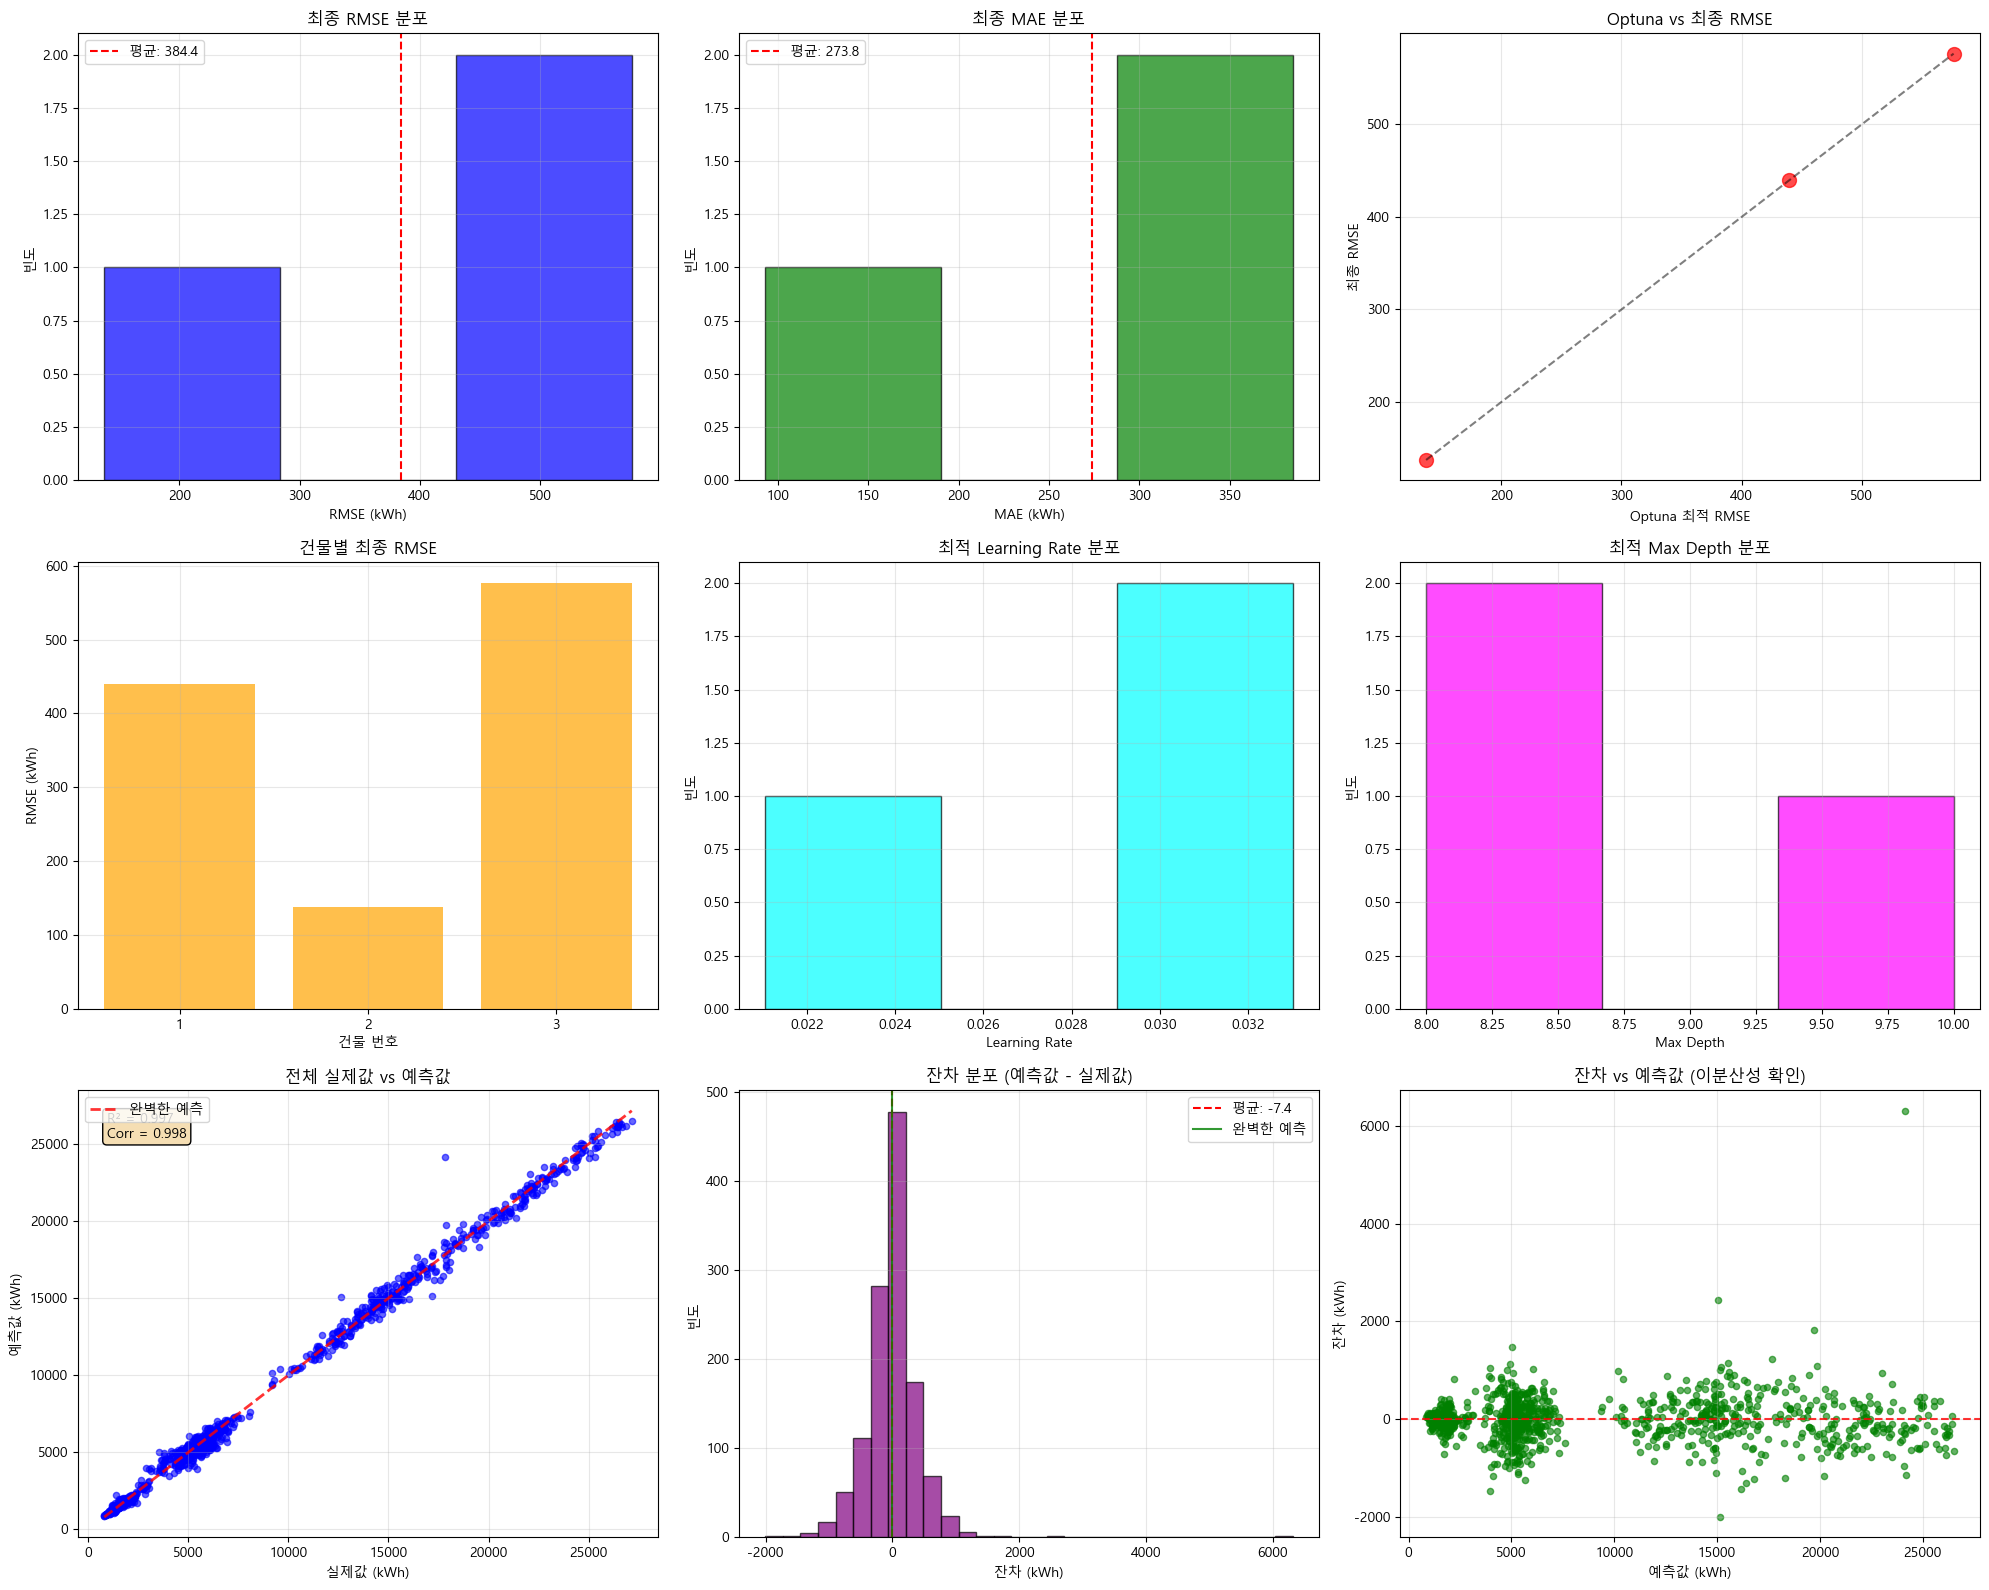

📊 Optuna 최적화 + 실제값 vs 예측값 분석 시각화 완료!

🔍 예측 성능 상세 분석:
   📊 전체 상관계수: 0.9983
   📊 전체 R² 스코어: 0.9966
   📊 평균 잔차: -7.39 kWh
   📊 잔차 표준편차: 425.88 kWh
   📊 MAPE: 4.93%

🎯 모델 예측 경향 분석:
   📈 과대추정: 629건 (51.4%)
   📉 과소추정: 595건 (48.6%)

📊 전력 사용량 구간별 성능:
   저사용량 (≤2860kWh): RMSE 138.77 kWh, MAPE 5.74%
   중사용량 (2860-9427kWh): RMSE 438.41 kWh, MAPE 6.69%
   고사용량 (>9427kWh): RMSE 576.64 kWh, MAPE 2.29%

📋 최적 하이퍼파라미터 통계:
   max_depth: 평균 8.667 ± 0.943 (범위: 8.000 ~ 10.000)
   learning_rate: 평균 0.028 ± 0.005 (범위: 0.021 ~ 0.033)
   n_estimators: 평균 333.667 ± 136.968 (범위: 145.000 ~ 466.000)
   subsample: 평균 0.894 ± 0.038 (범위: 0.857 ~ 0.946)
   colsample_bytree: 평균 0.844 ± 0.037 (범위: 0.796 ~ 0.886)


In [12]:
# 성능 시각화 (Optuna 최적화 + 실제값 vs 예측값 분석 포함)
fig, axes = plt.subplots(3, 3, figsize=(20, 16))

# RMSE 분포
axes[0, 0].hist(all_rmse, bins=max(3, len(all_rmse)//2), alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].axvline(np.mean(all_rmse), color='red', linestyle='--', label=f'평균: {np.mean(all_rmse):.1f}')
axes[0, 0].set_title('최종 RMSE 분포')
axes[0, 0].set_xlabel('RMSE (kWh)')
axes[0, 0].set_ylabel('빈도')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE 분포
axes[0, 1].hist(all_mae, bins=max(3, len(all_mae)//2), alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(np.mean(all_mae), color='red', linestyle='--', label=f'평균: {np.mean(all_mae):.1f}')
axes[0, 1].set_title('최종 MAE 분포')
axes[0, 1].set_xlabel('MAE (kWh)')
axes[0, 1].set_ylabel('빈도')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Optuna vs 최종 RMSE 비교
if building_study_results:
    optuna_rmse = [building_study_results[b]['best_value'] for b in building_scores.keys() if b in building_study_results]
    final_rmse = [building_scores[b]['rmse'] for b in building_scores.keys() if b in building_study_results]
    
    axes[0, 2].scatter(optuna_rmse, final_rmse, alpha=0.7, color='red', s=100)
    axes[0, 2].plot([min(optuna_rmse), max(optuna_rmse)], [min(optuna_rmse), max(optuna_rmse)], 'k--', alpha=0.5)
    axes[0, 2].set_title('Optuna vs 최종 RMSE')
    axes[0, 2].set_xlabel('Optuna 최적 RMSE')
    axes[0, 2].set_ylabel('최종 RMSE')
    axes[0, 2].grid(True, alpha=0.3)

# 건물별 RMSE
building_nums = list(building_scores.keys())
rmse_values = [building_scores[b]['rmse'] for b in building_nums]
axes[1, 0].bar(range(len(building_nums)), rmse_values, alpha=0.7, color='orange')
axes[1, 0].set_title('건물별 최종 RMSE')
axes[1, 0].set_xlabel('건물 번호')
axes[1, 0].set_ylabel('RMSE (kWh)')
axes[1, 0].set_xticks(range(len(building_nums)))
axes[1, 0].set_xticklabels(building_nums)
axes[1, 0].grid(True, alpha=0.3)

# 최적 하이퍼파라미터 분포 (learning_rate)
if building_best_params:
    lr_values = [params.get('learning_rate', 0) for params in building_best_params.values()]
    axes[1, 1].hist(lr_values, bins=max(3, len(lr_values)//2), alpha=0.7, color='cyan', edgecolor='black')
    axes[1, 1].set_title('최적 Learning Rate 분포')
    axes[1, 1].set_xlabel('Learning Rate')
    axes[1, 1].set_ylabel('빈도')
    axes[1, 1].grid(True, alpha=0.3)

# 최적 하이퍼파라미터 분포 (max_depth)
if building_best_params:
    depth_values = [params.get('max_depth', 0) for params in building_best_params.values()]
    axes[1, 2].hist(depth_values, bins=max(3, len(set(depth_values))), alpha=0.7, color='magenta', edgecolor='black')
    axes[1, 2].set_title('최적 Max Depth 분포')
    axes[1, 2].set_xlabel('Max Depth')
    axes[1, 2].set_ylabel('빈도')
    axes[1, 2].grid(True, alpha=0.3)

# === 새로운 추가: 실제값 vs 예측값 분석 ===

# 전체 건물 실제값 vs 예측값 (검증 데이터)
print("🔍 실제값 vs 예측값 분석을 위한 데이터 수집 중...")
all_y_true = []
all_y_pred = []
building_prediction_analysis = {}

for building_num in building_models.keys():
    # 해당 건물 데이터 다시 가져오기
    train_building = train_processed[train_processed['건물번호'] == building_num].copy()
    X_building = train_building[feature_columns].copy()
    y_building = train_building['전력소비량(kWh)'].copy()
    
    # 동일한 분할로 검증 데이터 생성
    X_train, X_val, y_train, y_val = train_test_split(
        X_building, y_building, test_size=0.2, random_state=42
    )
    
    # 모델로 검증 데이터 예측
    model = building_models[building_num]
    y_pred = model.predict(X_val)
    
    # 전체 데이터에 추가
    all_y_true.extend(y_val.values)
    all_y_pred.extend(y_pred)
    
    # 건물별 분석 데이터 저장
    building_prediction_analysis[building_num] = {
        'y_true': y_val.values,
        'y_pred': y_pred,
        'rmse': building_scores[building_num]['rmse'],
        'mae': building_scores[building_num]['mae']
    }

# 전체 실제값 vs 예측값 산점도
axes[2, 0].scatter(all_y_true, all_y_pred, alpha=0.6, s=20, color='blue')
min_val = min(min(all_y_true), min(all_y_pred))
max_val = max(max(all_y_true), max(all_y_pred))
axes[2, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='완벽한 예측')
axes[2, 0].set_title('전체 실제값 vs 예측값')
axes[2, 0].set_xlabel('실제값 (kWh)')
axes[2, 0].set_ylabel('예측값 (kWh)')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 상관계수 계산 및 표시
correlation = np.corrcoef(all_y_true, all_y_pred)[0, 1]
r2_score = correlation**2
axes[2, 0].text(0.05, 0.95, f'R² = {r2_score:.3f}\nCorr = {correlation:.3f}', 
                transform=axes[2, 0].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# 잔차 분포 (Residuals)
residuals = np.array(all_y_pred) - np.array(all_y_true)
axes[2, 1].hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[2, 1].axvline(np.mean(residuals), color='red', linestyle='--', label=f'평균: {np.mean(residuals):.1f}')
axes[2, 1].axvline(0, color='green', linestyle='-', alpha=0.8, label='완벽한 예측')
axes[2, 1].set_title('잔차 분포 (예측값 - 실제값)')
axes[2, 1].set_xlabel('잔차 (kWh)')
axes[2, 1].set_ylabel('빈도')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

# 잔차 vs 예측값 (이분산성 확인)
axes[2, 2].scatter(all_y_pred, residuals, alpha=0.6, s=20, color='green')
axes[2, 2].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[2, 2].set_title('잔차 vs 예측값 (이분산성 확인)')
axes[2, 2].set_xlabel('예측값 (kWh)')
axes[2, 2].set_ylabel('잔차 (kWh)')
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Optuna 최적화 + 실제값 vs 예측값 분석 시각화 완료!")

# 예측 성능 상세 분석
print(f"\n🔍 예측 성능 상세 분석:")
print(f"   📊 전체 상관계수: {correlation:.4f}")
print(f"   📊 전체 R² 스코어: {r2_score:.4f}")
print(f"   📊 평균 잔차: {np.mean(residuals):.2f} kWh")
print(f"   📊 잔차 표준편차: {np.std(residuals):.2f} kWh")
print(f"   📊 MAPE: {np.mean(np.abs(residuals) / np.array(all_y_true)) * 100:.2f}%")

# 예측 경향 분석
print(f"\n🎯 모델 예측 경향 분석:")
overestimation = np.sum(np.array(all_y_pred) > np.array(all_y_true))
underestimation = np.sum(np.array(all_y_pred) < np.array(all_y_true))
total_predictions = len(all_y_pred)

print(f"   📈 과대추정: {overestimation}건 ({overestimation/total_predictions*100:.1f}%)")
print(f"   📉 과소추정: {underestimation}건 ({underestimation/total_predictions*100:.1f}%)")

# 구간별 성능 분석
print(f"\n📊 전력 사용량 구간별 성능:")
low_threshold = np.percentile(all_y_true, 33)
high_threshold = np.percentile(all_y_true, 67)

low_mask = np.array(all_y_true) <= low_threshold
mid_mask = (np.array(all_y_true) > low_threshold) & (np.array(all_y_true) <= high_threshold)
high_mask = np.array(all_y_true) > high_threshold

for mask, label, threshold in [(low_mask, "저사용량", f"≤{low_threshold:.0f}kWh"), 
                               (mid_mask, "중사용량", f"{low_threshold:.0f}-{high_threshold:.0f}kWh"),
                               (high_mask, "고사용량", f">{high_threshold:.0f}kWh")]:
    if np.sum(mask) > 0:
        segment_rmse = np.sqrt(np.mean((np.array(all_y_pred)[mask] - np.array(all_y_true)[mask])**2))
        segment_mape = np.mean(np.abs((np.array(all_y_pred)[mask] - np.array(all_y_true)[mask]) / np.array(all_y_true)[mask])) * 100
        print(f"   {label} ({threshold}): RMSE {segment_rmse:.2f} kWh, MAPE {segment_mape:.2f}%")

# 추가: 최적 파라미터 요약 통계
if building_best_params:
    print(f"\n📋 최적 하이퍼파라미터 통계:")
    param_stats = {}
    for param_name in ['max_depth', 'learning_rate', 'n_estimators', 'subsample', 'colsample_bytree']:
        values = [params.get(param_name) for params in building_best_params.values() if params.get(param_name) is not None]
        if values:
            param_stats[param_name] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values)
            }
    
    for param, stats in param_stats.items():
        print(f"   {param}: 평균 {stats['mean']:.3f} ± {stats['std']:.3f} (범위: {stats['min']:.3f} ~ {stats['max']:.3f})")


In [13]:
def analyze_building_prediction_pattern(building_num, 
                                       building_models, 
                                       train_processed, 
                                       feature_columns):
    """
    n번째 건물의 시간별/요일별/주말별 예측 패턴 및 통계 분석 함수

    Args:
        building_num (int): 분석할 건물 번호
        building_models (dict): 건물별 학습된 모델 딕셔너리
        train_processed (pd.DataFrame): 전처리된 전체 학습 데이터
        feature_columns (list): 모델 입력 피처 리스트
    """
    if building_num not in building_models:
        print(f"❌ 건물 {building_num}에 대한 모델이 없습니다.")
        return

    print(f"\n🕐 시간별 예측 패턴 분석 (건물 {building_num} 기준)")
    print("="*50)
    
    # 해당 건물의 전체 데이터 가져오기
    train_building = train_processed[train_processed['건물번호'] == building_num].copy()
    X_building = train_building[feature_columns].copy()
    y_building = train_building['전력소비량(kWh)'].copy()
    
    # 시간 정보 추가
    time_info = train_building[['일시', '시간', '요일', '주말여부']].copy()
    
    # 전체 데이터로 예측
    model = building_models[building_num]
    y_pred_full = model.predict(X_building)
    
    # 시간별 분석을 위한 데이터 준비
    analysis_df = pd.DataFrame({
        '실제값': y_building,
        '예측값': y_pred_full,
        '시간': time_info['시간'],
        '요일': time_info['요일'],
        '주말여부': time_info['주말여부'],
        '일시': time_info['일시']
    })
    
    # 잔차 계산
    analysis_df['잔차'] = analysis_df['예측값'] - analysis_df['실제값']
    analysis_df['절대잔차'] = np.abs(analysis_df['잔차'])
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 시간대별 평균 실제값 vs 예측값
    hourly_stats = analysis_df.groupby('시간').agg({
        '실제값': 'mean',
        '예측값': 'mean',
        '절대잔차': 'mean'
    }).reset_index()
    
    axes[0, 0].plot(hourly_stats['시간'], hourly_stats['실제값'], 'b-', marker='o', label='실제값', linewidth=2)
    axes[0, 0].plot(hourly_stats['시간'], hourly_stats['예측값'], 'r--', marker='s', label='예측값', linewidth=2)
    axes[0, 0].set_title(f'건물 {building_num} - 시간대별 평균 전력소비량')
    axes[0, 0].set_xlabel('시간')
    axes[0, 0].set_ylabel('전력소비량 (kWh)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xticks(range(0, 24, 2))
    
    # 2. 시간대별 예측 오차
    axes[0, 1].bar(hourly_stats['시간'], hourly_stats['절대잔차'], alpha=0.7, color='orange')
    axes[0, 1].set_title(f'건물 {building_num} - 시간대별 평균 절대 오차')
    axes[0, 1].set_xlabel('시간')
    axes[0, 1].set_ylabel('평균 절대 오차 (kWh)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks(range(0, 24, 2))
    
    # 3. 요일별 성능
    daily_stats = analysis_df.groupby('요일').agg({
        '실제값': 'mean',
        '예측값': 'mean',
        '절대잔차': 'mean'
    }).reset_index()
    
    weekday_names = ['월', '화', '수', '목', '금', '토', '일']
    daily_stats['요일명'] = daily_stats['요일'].map(lambda x: weekday_names[x])
    
    x_pos = range(len(daily_stats))
    width = 0.35
    
    axes[1, 0].bar([p - width/2 for p in x_pos], daily_stats['실제값'], 
                   width, label='실제값', alpha=0.7, color='blue')
    axes[1, 0].bar([p + width/2 for p in x_pos], daily_stats['예측값'], 
                   width, label='예측값', alpha=0.7, color='red')
    axes[1, 0].set_title(f'건물 {building_num} - 요일별 평균 전력소비량')
    axes[1, 0].set_xlabel('요일')
    axes[1, 0].set_ylabel('전력소비량 (kWh)')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(daily_stats['요일명'])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 주말 vs 평일 비교
    weekend_stats = analysis_df.groupby('주말여부').agg({
        '실제값': 'mean',
        '예측값': 'mean',
        '절대잔차': 'mean'
    }).reset_index()
    
    weekend_labels = ['평일', '주말']
    weekend_stats['구분'] = weekend_stats['주말여부'].map(lambda x: weekend_labels[x])
    
    x_pos = range(len(weekend_stats))
    axes[1, 1].bar([p - width/2 for p in x_pos], weekend_stats['실제값'], 
                   width, label='실제값', alpha=0.7, color='blue')
    axes[1, 1].bar([p + width/2 for p in x_pos], weekend_stats['예측값'], 
                   width, label='예측값', alpha=0.7, color='red')
    axes[1, 1].set_title(f'건물 {building_num} - 평일 vs 주말 전력소비량')
    axes[1, 1].set_xlabel('구분')
    axes[1, 1].set_ylabel('전력소비량 (kWh)')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(weekend_stats['구분'])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 시간별 성능 통계 출력
    print(f"\n📊 시간별 예측 성능 분석:")
    
    # 가장 정확한/부정확한 시간대
    best_hour = hourly_stats.loc[hourly_stats['절대잔차'].idxmin()]
    worst_hour = hourly_stats.loc[hourly_stats['절대잔차'].idxmax()]
    
    print(f"   🏆 가장 정확한 시간대: {best_hour['시간']:.0f}시 (평균 절대오차: {best_hour['절대잔차']:.2f} kWh)")
    print(f"   ⚠️ 가장 부정확한 시간대: {worst_hour['시간']:.0f}시 (평균 절대오차: {worst_hour['절대잔차']:.2f} kWh)")
    
    # 요일별 성능
    best_day = daily_stats.loc[daily_stats['절대잔차'].idxmin()]
    worst_day = daily_stats.loc[daily_stats['절대잔차'].idxmax()]
    
    print(f"   🏆 가장 정확한 요일: {best_day['요일명']} (평균 절대오차: {best_day['절대잔차']:.2f} kWh)")
    print(f"   ⚠️ 가장 부정확한 요일: {worst_day['요일명']} (평균 절대오차: {worst_day['절대잔차']:.2f} kWh)")
    
    # 평일 vs 주말 성능 비교
    weekday_error = weekend_stats[weekend_stats['주말여부'] == 0]['절대잔차'].values[0]
    weekend_error = weekend_stats[weekend_stats['주말여부'] == 1]['절대잔차'].values[0]
    
    print(f"   📊 평일 평균 절대오차: {weekday_error:.2f} kWh")
    print(f"   📊 주말 평균 절대오차: {weekend_error:.2f} kWh")
    
    if weekend_error > weekday_error:
        print(f"   💡 주말이 평일보다 예측하기 어려움 (+{weekend_error - weekday_error:.2f} kWh)")
    else:
        print(f"   💡 평일이 주말보다 예측하기 어려움 (+{weekday_error - weekend_error:.2f} kWh)")
    
    # 피크 시간대 분석
    peak_hours = hourly_stats.nlargest(3, '실제값')['시간'].values
    off_peak_hours = hourly_stats.nsmallest(3, '실제값')['시간'].values
    
    print(f"   ⚡ 피크 시간대: {', '.join([f'{h:.0f}시' for h in peak_hours])}")
    print(f"   🌙 비피크 시간대: {', '.join([f'{h:.0f}시' for h in off_peak_hours])}")
    
    # 피크 vs 비피크 예측 정확도
    peak_mask = analysis_df['시간'].isin(peak_hours)
    off_peak_mask = analysis_df['시간'].isin(off_peak_hours)
    
    peak_mae = analysis_df[peak_mask]['절대잔차'].mean()
    off_peak_mae = analysis_df[off_peak_mask]['절대잔차'].mean()
    
    print(f"   📈 피크 시간대 평균 절대오차: {peak_mae:.2f} kWh")
    print(f"   📉 비피크 시간대 평균 절대오차: {off_peak_mae:.2f} kWh")

# 사용 예시:
# analyze_building_prediction_pattern(원하는_건물번호, building_models, train_processed, feature_columns)



🕐 시간별 예측 패턴 분석 (건물 1 기준)


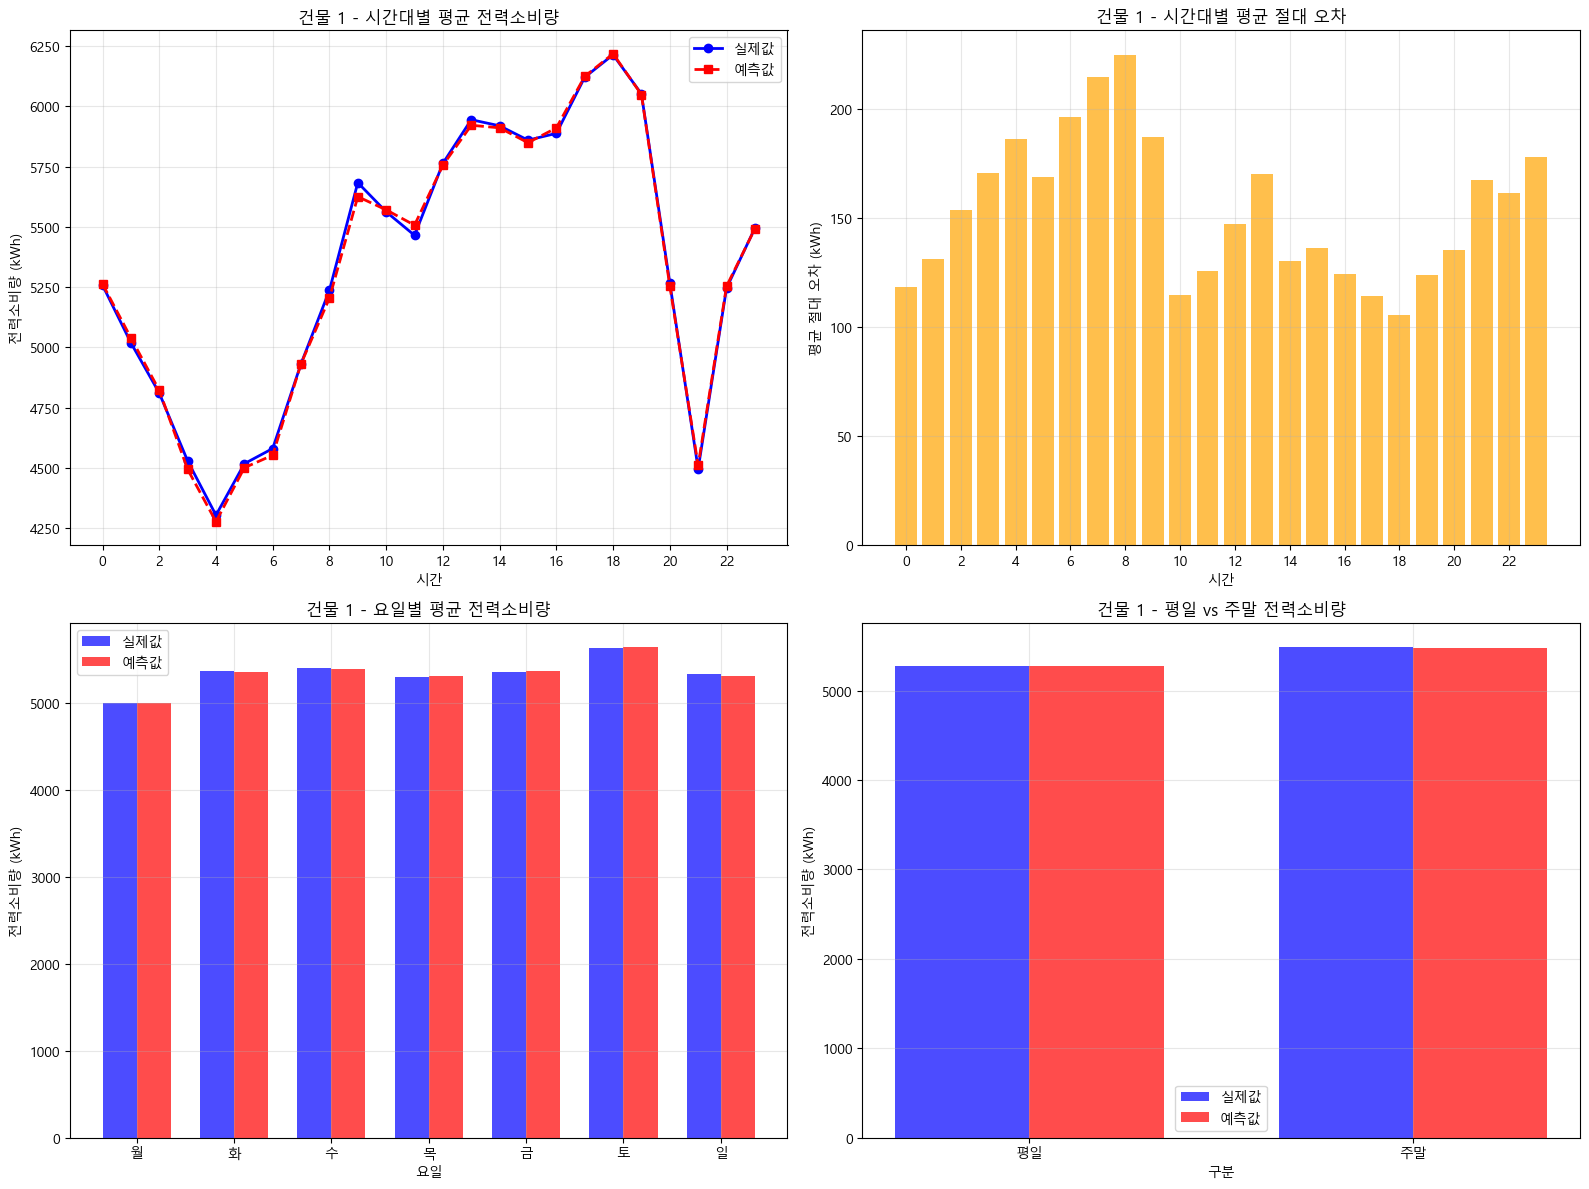


📊 시간별 예측 성능 분석:
   🏆 가장 정확한 시간대: 18시 (평균 절대오차: 105.71 kWh)
   ⚠️ 가장 부정확한 시간대: 8시 (평균 절대오차: 224.83 kWh)
   🏆 가장 정확한 요일: 토 (평균 절대오차: 134.82 kWh)
   ⚠️ 가장 부정확한 요일: 금 (평균 절대오차: 174.49 kWh)
   📊 평일 평균 절대오차: 157.74 kWh
   📊 주말 평균 절대오차: 143.86 kWh
   💡 평일이 주말보다 예측하기 어려움 (+13.88 kWh)
   ⚡ 피크 시간대: 18시, 17시, 19시
   🌙 비피크 시간대: 4시, 21시, 5시
   📈 피크 시간대 평균 절대오차: 114.66 kWh
   📉 비피크 시간대 평균 절대오차: 174.11 kWh


In [15]:
analyze_building_prediction_pattern(1, building_models, train_processed, feature_columns)


🏢 개별 건물별 예측 성능 상세 분석


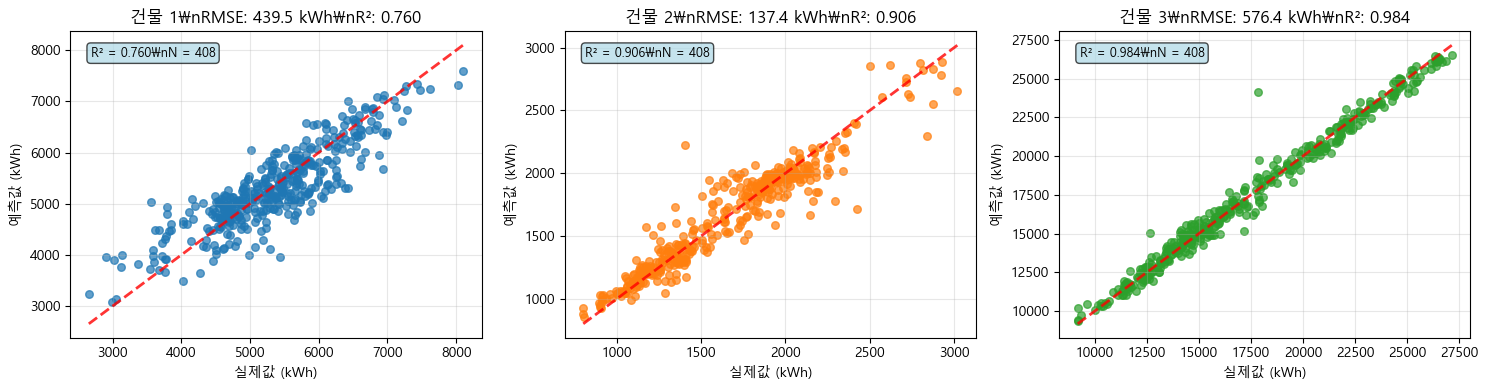

\n📊 건물별 성능 순위 (RMSE 기준):
\n🏆 성능 우수 건물 TOP 3:
   1. 건물 2: RMSE 137.38 kWh, R² 0.906, MAPE 5.7%
   2. 건물 1: RMSE 439.46 kWh, R² 0.760, MAPE 6.8%
   3. 건물 3: RMSE 576.45 kWh, R² 0.984, MAPE 2.3%
\n🔍 예측 패턴 종합 분석:
   📊 평균 편향: -7.39 kWh (-0.2%)
   📊 편향 표준편차: 13.52 kWh
   📈 과대추정 건물: 1개 (33.3%)
   📉 과소추정 건물: 2개 (66.7%)
   🔗 전력사용량-RMSE 상관관계: 0.871
      → 고사용량 건물일수록 예측 오차가 큰 경향
\n🎯 개별 건물 예측 성능 분석 완료!


In [14]:
# 개별 건물별 실제값 vs 예측값 상세 분석
print("\n" + "="*60)
print("🏢 개별 건물별 예측 성능 상세 분석")
print("="*60)

# 훈련된 건물들의 개별 분석
n_buildings = len(building_models)
if n_buildings > 0:
    # 건물 수에 따라 그래프 레이아웃 결정
    if n_buildings <= 3:
        cols = n_buildings
        rows = 1
    elif n_buildings <= 6:
        cols = 3
        rows = 2
    else:
        cols = 3
        rows = min(3, (n_buildings + 2) // 3)  # 최대 9개까지만 표시
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_buildings == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if hasattr(axes, '__len__') else [axes]
    else:
        axes = axes.flatten()
    
    # 각 건물별 실제값 vs 예측값 플롯
    for idx, building_num in enumerate(list(building_models.keys())[:min(9, n_buildings)]):  # 최대 9개까지
        analysis_data = building_prediction_analysis[building_num]
        y_true = analysis_data['y_true']
        y_pred = analysis_data['y_pred']
        
        # 산점도
        axes[idx].scatter(y_true, y_pred, alpha=0.7, s=30, color=f'C{idx}')
        
        # 완벽한 예측 라인
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
        
        # 상관계수 및 R² 계산
        if len(y_true) > 1:
            corr = np.corrcoef(y_true, y_pred)[0, 1]
            r2 = corr**2
        else:
            corr, r2 = 0, 0
        
        # 그래프 설정
        axes[idx].set_title(f'건물 {building_num}\\nRMSE: {analysis_data["rmse"]:.1f} kWh\\nR²: {r2:.3f}')
        axes[idx].set_xlabel('실제값 (kWh)')
        axes[idx].set_ylabel('예측값 (kWh)')
        axes[idx].grid(True, alpha=0.3)
        
        # 통계 정보 표시
        axes[idx].text(0.05, 0.95, f'R² = {r2:.3f}\\nN = {len(y_true)}', 
                       transform=axes[idx].transAxes, fontsize=9,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # 빈 subplot 제거
    for idx in range(min(9, n_buildings), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    # 건물별 성능 순위
    print(f"\\n📊 건물별 성능 순위 (RMSE 기준):")
    sorted_buildings = sorted(building_prediction_analysis.items(), 
                             key=lambda x: x[1]['rmse'])
    
    print("\\n🏆 성능 우수 건물 TOP 3:")
    for i, (building_num, data) in enumerate(sorted_buildings[:3], 1):
        y_true = data['y_true']
        y_pred = data['y_pred']
        corr = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else 0
        mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100
        print(f"   {i}. 건물 {building_num}: RMSE {data['rmse']:.2f} kWh, R² {corr**2:.3f}, MAPE {mape:.1f}%")
    
    if len(sorted_buildings) > 3:
        print("\\n⚠️ 개선 필요 건물 TOP 3:")
        for i, (building_num, data) in enumerate(sorted_buildings[-3:], 1):
            y_true = data['y_true']
            y_pred = data['y_pred']
            corr = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else 0
            mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100
            print(f"   {i}. 건물 {building_num}: RMSE {data['rmse']:.2f} kWh, R² {corr**2:.3f}, MAPE {mape:.1f}%")
    
    # 예측 패턴 분석
    print(f"\\n🔍 예측 패턴 종합 분석:")
    
    # 각 건물별 편향 분석
    bias_analysis = []
    for building_num, data in building_prediction_analysis.items():
        y_true = data['y_true']
        y_pred = data['y_pred']
        bias = np.mean(y_pred - y_true)  # 양수면 과대추정, 음수면 과소추정
        bias_pct = (bias / np.mean(y_true)) * 100
        
        bias_analysis.append({
            'building': building_num,
            'bias': bias,
            'bias_pct': bias_pct,
            'avg_consumption': np.mean(y_true)
        })
    
    # 편향 통계
    all_bias = [b['bias'] for b in bias_analysis]
    all_bias_pct = [b['bias_pct'] for b in bias_analysis]
    
    print(f"   📊 평균 편향: {np.mean(all_bias):.2f} kWh ({np.mean(all_bias_pct):.1f}%)")
    print(f"   📊 편향 표준편차: {np.std(all_bias):.2f} kWh")
    
    # 과대/과소 추정 건물 분류
    overestimating_buildings = [b for b in bias_analysis if b['bias'] > 0]
    underestimating_buildings = [b for b in bias_analysis if b['bias'] < 0]
    
    print(f"   📈 과대추정 건물: {len(overestimating_buildings)}개 ({len(overestimating_buildings)/len(bias_analysis)*100:.1f}%)")
    print(f"   📉 과소추정 건물: {len(underestimating_buildings)}개 ({len(underestimating_buildings)/len(bias_analysis)*100:.1f}%)")
    
    # 전력 사용량과 예측 정확도 관계 분석
    consumption_levels = [b['avg_consumption'] for b in bias_analysis]
    rmse_values = [building_prediction_analysis[b['building']]['rmse'] for b in bias_analysis]
    
    if len(consumption_levels) > 1:
        consumption_rmse_corr = np.corrcoef(consumption_levels, rmse_values)[0, 1]
        print(f"   🔗 전력사용량-RMSE 상관관계: {consumption_rmse_corr:.3f}")
        
        if consumption_rmse_corr > 0.3:
            print("      → 고사용량 건물일수록 예측 오차가 큰 경향")
        elif consumption_rmse_corr < -0.3:
            print("      → 저사용량 건물일수록 예측 오차가 큰 경향")
        else:
            print("      → 전력사용량과 예측 오차 간 명확한 상관관계 없음")

print("\\n🎯 개별 건물 예측 성능 분석 완료!")


In [34]:
def analyze_building_prediction_pattern(building_num, 
                                       building_models, 
                                       train_processed, 
                                       feature_columns):
    """
    n번째 건물의 시간별/요일별/주말별 예측 패턴 및 통계 분석 함수

    Args:
        building_num (int): 분석할 건물 번호
        building_models (dict): 건물별 학습된 모델 딕셔너리
        train_processed (pd.DataFrame): 전처리된 전체 학습 데이터
        feature_columns (list): 모델 입력 피처 리스트
    """
    if building_num not in building_models:
        print(f"❌ 건물 {building_num}에 대한 모델이 없습니다.")
        return

    print(f"\n🕐 시간별 예측 패턴 분석 (건물 {building_num} 기준)")
    print("="*50)
    
    # 해당 건물의 전체 데이터 가져오기
    train_building = train_processed[train_processed['건물번호'] == building_num].copy()
    X_building = train_building[feature_columns].copy()
    y_building = train_building['전력소비량(kWh)'].copy()
    
    # 시간 정보 추가
    time_info = train_building[['일시', '시간', '요일', '주말여부']].copy()
    
    # 전체 데이터로 예측
    model = building_models[building_num]
    y_pred_full = model.predict(X_building)
    
    # 시간별 분석을 위한 데이터 준비
    analysis_df = pd.DataFrame({
        '실제값': y_building,
        '예측값': y_pred_full,
        '시간': time_info['시간'],
        '요일': time_info['요일'],
        '주말여부': time_info['주말여부'],
        '일시': time_info['일시']
    })
    
    # 잔차 계산
    analysis_df['잔차'] = analysis_df['예측값'] - analysis_df['실제값']
    analysis_df['절대잔차'] = np.abs(analysis_df['잔차'])
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 시간대별 평균 실제값 vs 예측값
    hourly_stats = analysis_df.groupby('시간').agg({
        '실제값': 'mean',
        '예측값': 'mean',
        '절대잔차': 'mean'
    }).reset_index()
    
    axes[0, 0].plot(hourly_stats['시간'], hourly_stats['실제값'], 'b-', marker='o', label='실제값', linewidth=2)
    axes[0, 0].plot(hourly_stats['시간'], hourly_stats['예측값'], 'r--', marker='s', label='예측값', linewidth=2)
    axes[0, 0].set_title(f'건물 {building_num} - 시간대별 평균 전력소비량')
    axes[0, 0].set_xlabel('시간')
    axes[0, 0].set_ylabel('전력소비량 (kWh)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xticks(range(0, 24, 2))
    
    # 2. 시간대별 예측 오차
    axes[0, 1].bar(hourly_stats['시간'], hourly_stats['절대잔차'], alpha=0.7, color='orange')
    axes[0, 1].set_title(f'건물 {building_num} - 시간대별 평균 절대 오차')
    axes[0, 1].set_xlabel('시간')
    axes[0, 1].set_ylabel('평균 절대 오차 (kWh)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks(range(0, 24, 2))
    
    # 3. 요일별 성능
    daily_stats = analysis_df.groupby('요일').agg({
        '실제값': 'mean',
        '예측값': 'mean',
        '절대잔차': 'mean'
    }).reset_index()
    
    weekday_names = ['월', '화', '수', '목', '금', '토', '일']
    daily_stats['요일명'] = daily_stats['요일'].map(lambda x: weekday_names[x])
    
    x_pos = range(len(daily_stats))
    width = 0.35
    
    axes[1, 0].bar([p - width/2 for p in x_pos], daily_stats['실제값'], 
                   width, label='실제값', alpha=0.7, color='blue')
    axes[1, 0].bar([p + width/2 for p in x_pos], daily_stats['예측값'], 
                   width, label='예측값', alpha=0.7, color='red')
    axes[1, 0].set_title(f'건물 {building_num} - 요일별 평균 전력소비량')
    axes[1, 0].set_xlabel('요일')
    axes[1, 0].set_ylabel('전력소비량 (kWh)')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(daily_stats['요일명'])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 주말 vs 평일 비교
    weekend_stats = analysis_df.groupby('주말여부').agg({
        '실제값': 'mean',
        '예측값': 'mean',
        '절대잔차': 'mean'
    }).reset_index()
    
    weekend_labels = ['평일', '주말']
    weekend_stats['구분'] = weekend_stats['주말여부'].map(lambda x: weekend_labels[x])
    
    x_pos = range(len(weekend_stats))
    axes[1, 1].bar([p - width/2 for p in x_pos], weekend_stats['실제값'], 
                   width, label='실제값', alpha=0.7, color='blue')
    axes[1, 1].bar([p + width/2 for p in x_pos], weekend_stats['예측값'], 
                   width, label='예측값', alpha=0.7, color='red')
    axes[1, 1].set_title(f'건물 {building_num} - 평일 vs 주말 전력소비량')
    axes[1, 1].set_xlabel('구분')
    axes[1, 1].set_ylabel('전력소비량 (kWh)')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(weekend_stats['구분'])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 시간별 성능 통계 출력
    print(f"\n📊 시간별 예측 성능 분석:")
    
    # 가장 정확한/부정확한 시간대
    best_hour = hourly_stats.loc[hourly_stats['절대잔차'].idxmin()]
    worst_hour = hourly_stats.loc[hourly_stats['절대잔차'].idxmax()]
    
    print(f"   🏆 가장 정확한 시간대: {best_hour['시간']:.0f}시 (평균 절대오차: {best_hour['절대잔차']:.2f} kWh)")
    print(f"   ⚠️ 가장 부정확한 시간대: {worst_hour['시간']:.0f}시 (평균 절대오차: {worst_hour['절대잔차']:.2f} kWh)")
    
    # 요일별 성능
    best_day = daily_stats.loc[daily_stats['절대잔차'].idxmin()]
    worst_day = daily_stats.loc[daily_stats['절대잔차'].idxmax()]
    
    print(f"   🏆 가장 정확한 요일: {best_day['요일명']} (평균 절대오차: {best_day['절대잔차']:.2f} kWh)")
    print(f"   ⚠️ 가장 부정확한 요일: {worst_day['요일명']} (평균 절대오차: {worst_day['절대잔차']:.2f} kWh)")
    
    # 평일 vs 주말 성능 비교
    weekday_error = weekend_stats[weekend_stats['주말여부'] == 0]['절대잔차'].values[0]
    weekend_error = weekend_stats[weekend_stats['주말여부'] == 1]['절대잔차'].values[0]
    
    print(f"   📊 평일 평균 절대오차: {weekday_error:.2f} kWh")
    print(f"   📊 주말 평균 절대오차: {weekend_error:.2f} kWh")
    
    if weekend_error > weekday_error:
        print(f"   💡 주말이 평일보다 예측하기 어려움 (+{weekend_error - weekday_error:.2f} kWh)")
    else:
        print(f"   💡 평일이 주말보다 예측하기 어려움 (+{weekday_error - weekend_error:.2f} kWh)")
    
    # 피크 시간대 분석
    peak_hours = hourly_stats.nlargest(3, '실제값')['시간'].values
    off_peak_hours = hourly_stats.nsmallest(3, '실제값')['시간'].values
    
    print(f"   ⚡ 피크 시간대: {', '.join([f'{h:.0f}시' for h in peak_hours])}")
    print(f"   🌙 비피크 시간대: {', '.join([f'{h:.0f}시' for h in off_peak_hours])}")
    
    # 피크 vs 비피크 예측 정확도
    peak_mask = analysis_df['시간'].isin(peak_hours)
    off_peak_mask = analysis_df['시간'].isin(off_peak_hours)
    
    peak_mae = analysis_df[peak_mask]['절대잔차'].mean()
    off_peak_mae = analysis_df[off_peak_mask]['절대잔차'].mean()
    
    print(f"   📈 피크 시간대 평균 절대오차: {peak_mae:.2f} kWh")
    print(f"   📉 비피크 시간대 평균 절대오차: {off_peak_mae:.2f} kWh")

# 사용 예시:
# analyze_building_prediction_pattern(원하는_건물번호, building_models, train_processed, feature_columns)



🕐 시간별 예측 패턴 분석 (건물 3 기준)


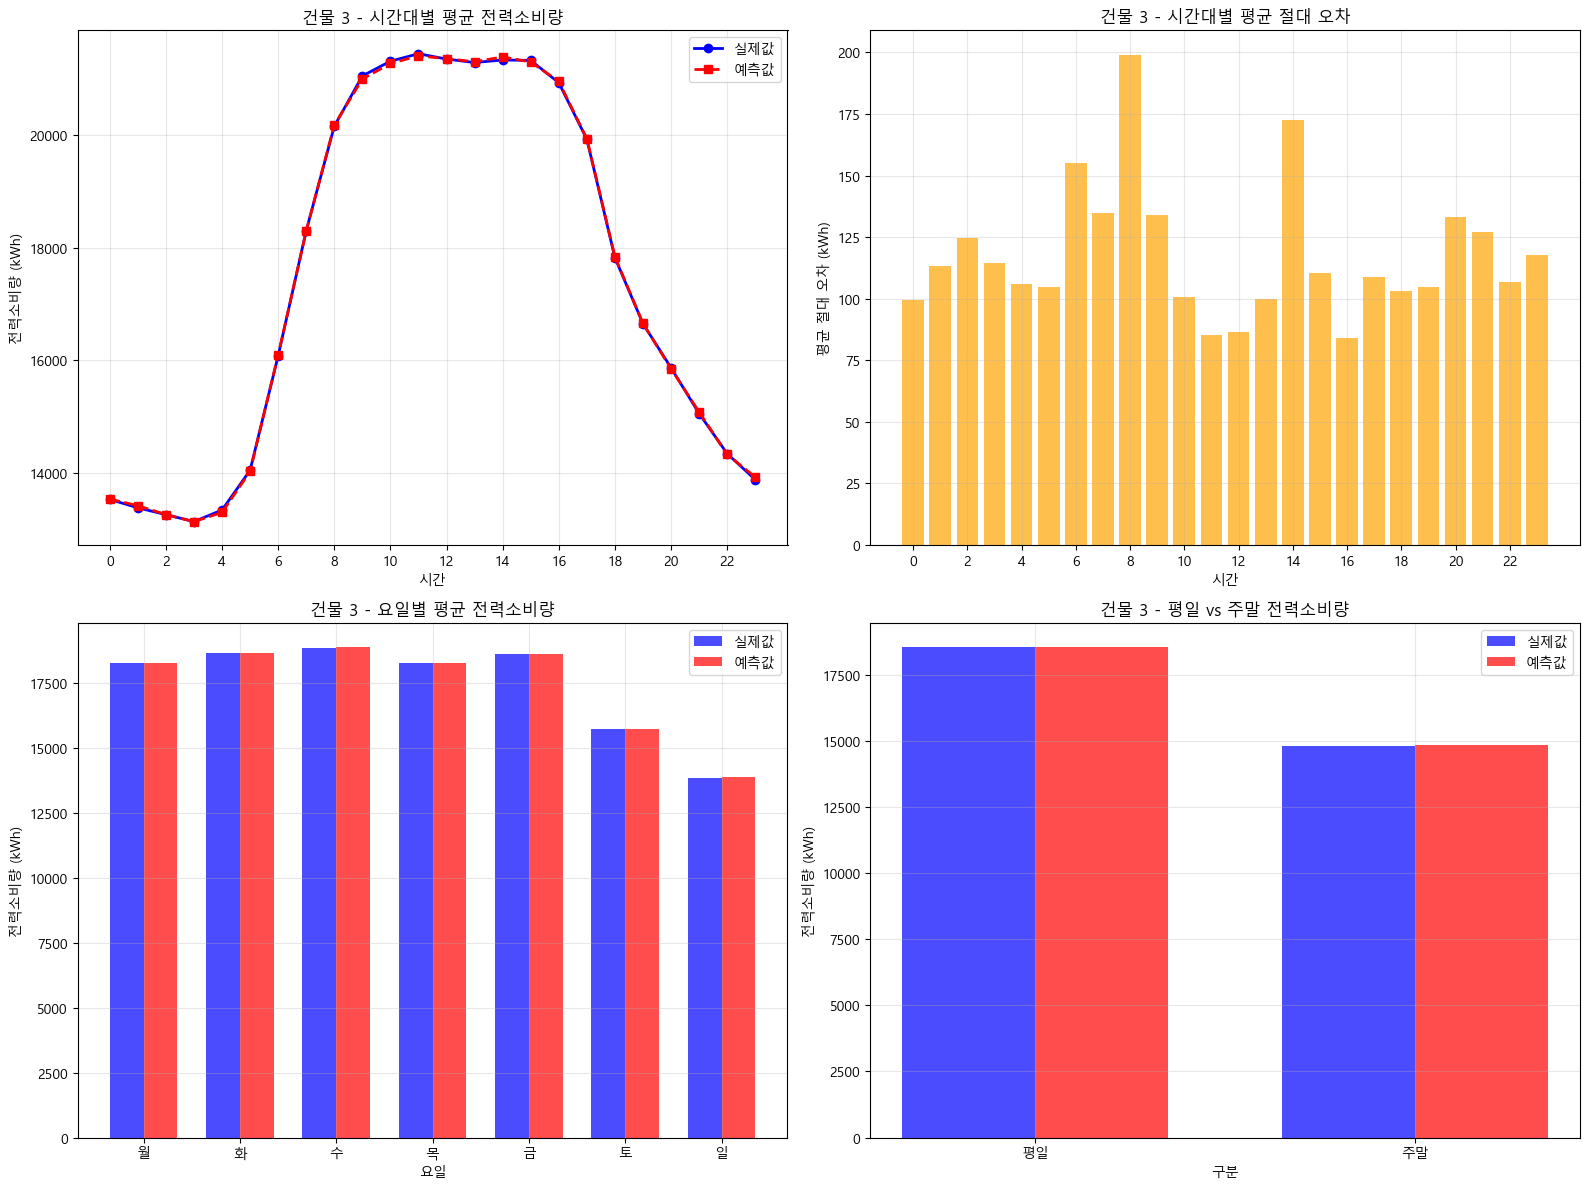


📊 시간별 예측 성능 분석:
   🏆 가장 정확한 시간대: 16시 (평균 절대오차: 83.87 kWh)
   ⚠️ 가장 부정확한 시간대: 8시 (평균 절대오차: 199.04 kWh)
   🏆 가장 정확한 요일: 화 (평균 절대오차: 97.20 kWh)
   ⚠️ 가장 부정확한 요일: 목 (평균 절대오차: 154.99 kWh)
   📊 평일 평균 절대오차: 120.99 kWh
   📊 주말 평균 절대오차: 110.03 kWh
   💡 평일이 주말보다 예측하기 어려움 (+10.96 kWh)
   ⚡ 피크 시간대: 11시, 12시, 14시
   🌙 비피크 시간대: 3시, 2시, 4시
   📈 피크 시간대 평균 절대오차: 114.81 kWh
   📉 비피크 시간대 평균 절대오차: 115.06 kWh


In [36]:
analyze_building_prediction_pattern(3, building_models, train_processed, feature_columns)

🔍 건물 1 모델의 피처 중요도 TOP 10:


,feature,importance
15,THI,0.190644
11,시간,0.164779
9,월,0.142758
14,CDH,0.106653
13,주말여부,0.098002
12,요일,0.096224
1,기온(°C),0.058917
10,일,0.043340
4,습도(%),0.039829
2,강수량(mm),0.030128


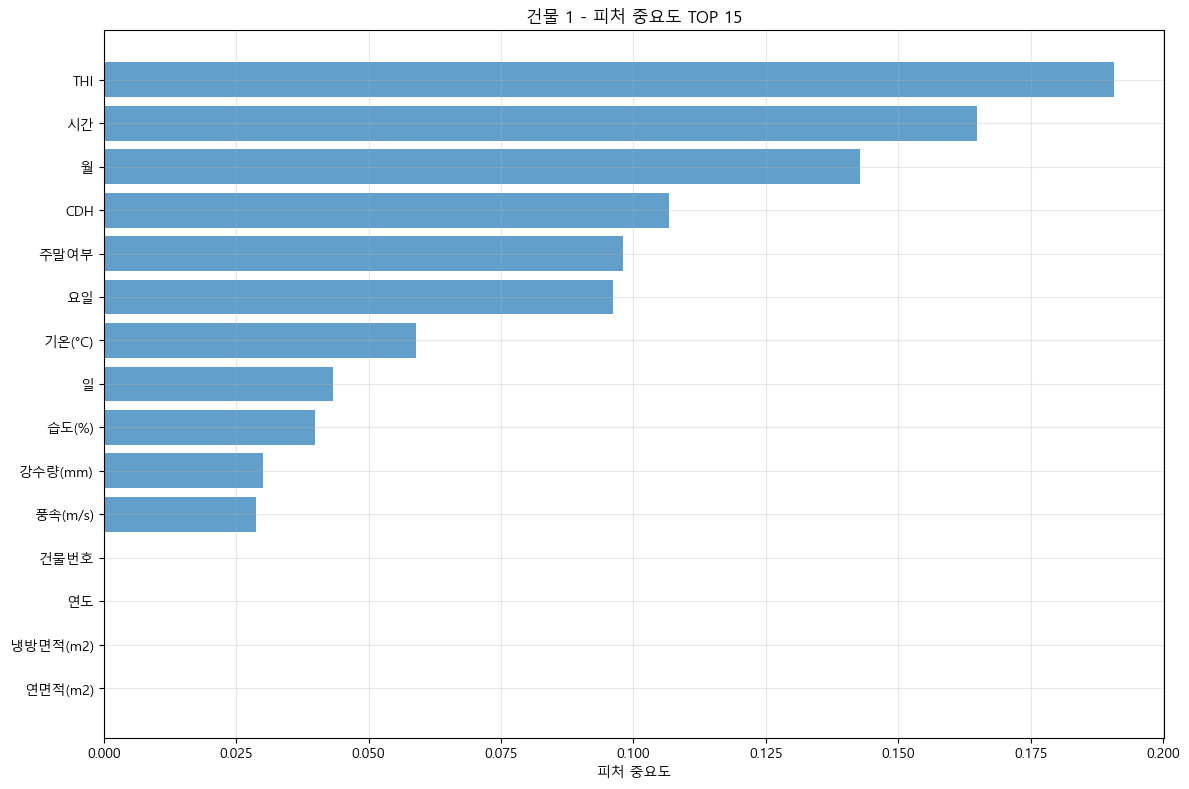

🔍 피처 중요도 분석 완료!


In [16]:
# 첫 번째 건물 모델의 피처 중요도 분석 (예시)
first_building = list(building_models.keys())[0]
first_model = building_models[first_building]

# 피처 중요도 추출
feature_importance = first_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"🔍 건물 {first_building} 모델의 피처 중요도 TOP 10:")
display(feature_importance_df.head(10))

# 피처 중요도 시각화
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('피처 중요도')
plt.title(f'건물 {first_building} - 피처 중요도 TOP 15')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("🔍 피처 중요도 분석 완료!")


In [21]:
# 전체 건물에 대한 Optuna 최적화 모델 훈련 (DACON 1위 솔루션 방식)
# 시연에서는 일부만 했으므로 전체 실행이 필요합니다

print("🏢 전체 건물 Optuna 최적화 모델 훈련 시작 (DACON 1위 솔루션 방식)")
print("⚠️ 이 셀은 시간이 매우 오래 걸릴 수 있습니다. (약 1-3시간)")
print("💡 건물당 평균 2-5분 소요 (100개 건물 × 100 trials)")
print("🔧 시계열 특성 고려: 마지막 2주(336시간)를 검증 데이터로 사용")
print("=" * 60)

# 전체 실행용 설정
full_n_trials = 100  # 전체 실행 시 더 많은 시도
sampler = TPESampler(seed=42)

# 전체 건물 훈련
for idx, building_num in enumerate(unique_buildings, 1):
    if building_num in building_models:
        continue  # 이미 훈련된 건물은 건너뛰기
    
    print(f"\\n🏢 건물 {building_num} Optuna 최적화 중... ({idx}/{total_buildings})")
    
    # 해당 건물 데이터 필터링
    train_building = train_processed[train_processed['건물번호'] == building_num].copy()
    test_building = test_processed[test_processed['건물번호'] == building_num].copy()
    
    # 피처와 타겟 분리
    X_building = train_building[feature_columns].copy()
    y_building = train_building['전력소비량(kWh)'].copy()
    X_test_building = test_building[feature_columns].copy()
    
    # DACON 1위 솔루션 방식: 시계열 특성을 고려한 train/validation 분할
    # 마지막 2주(336시간) 데이터를 검증용으로 사용
    n_valid = 24 * 14  # 2주 = 336시간
    X_train, X_val = X_building.iloc[:-n_valid], X_building.iloc[-n_valid:]
    y_train, y_val = y_building.iloc[:-n_valid], y_building.iloc[-n_valid:]
    
    print(f"   📊 시계열 분할 - 훈련: {len(X_train)}개, 검증: {len(X_val)}개 (마지막 2주)")
    # Optuna 스터디 생성 및 실행 (DACON 1위 솔루션 방식)
    study = optuna.create_study(
        direction='minimize',
        sampler=sampler,
        study_name=f'building_{building_num}_optimization_full'
    )
    
    # DACON 1위 솔루션의 objective 함수 사용 (시계열 분할 방식)
    study.optimize(lambda trial: objective(trial, X_building, y_building), n_trials=full_n_trials, show_progress_bar=False)
    
    # 최적 파라미터로 최종 모델 훈련
    best_params = study.best_params
    
    final_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'verbosity': 0,
        'random_state': 42,
        'n_jobs': -1,
        **best_params
    }
    
    final_model = xgb.XGBRegressor(**final_params)
    
    try:
        # DACON 1위 솔루션 방식: early_stopping_rounds=20 사용
        final_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=20,
            verbose=False
        )
    except TypeError:
        final_model.fit(X_train, y_train)
    
    # 최종 성능 평가 (DACON 1위 솔루션과 동일한 평가 방식)
    val_pred = final_model.predict(X_val)
    metrics = calculate_metrics(y_val, val_pred)
    
    print(f"   📈 최종 검증 RMSE: {metrics['RMSE']:.2f} kWh")
    print(f"   📈 최종 검증 SMAPE: {metrics['SMAPE']:.2f}%")
    
    # 테스트 데이터 예측
    test_pred = final_model.predict(X_test_building)
    test_pred = np.maximum(test_pred, 0)
    
    # 결과 저장 (DACON 1위 솔루션과 동일한 평가 지표 포함)
    building_models[building_num] = final_model
    building_predictions[building_num] = test_pred
    building_scores[building_num] = {
        'rmse': metrics['RMSE'], 
        'mae': metrics['MAE'],
        'smape': metrics['SMAPE'],
        'mape': metrics['MAPE']
    }
    building_best_params[building_num] = best_params
    building_study_results[building_num] = {
        'best_value': study.best_value,
        'n_trials': len(study.trials),
        'best_trial': study.best_trial.number
    }
    
    # 진행률 출력
    if idx % 10 == 0:
        avg_rmse = np.mean([building_scores[b]['rmse'] for b in building_scores.keys()])
        print(f"   ⏳ 진행률: {idx}/{total_buildings} ({idx/total_buildings*100:.1f}%) | 평균 RMSE: {avg_rmse:.2f}")

print(f"\\n✅ 전체 {len(building_models)}개 건물 Optuna 최적화 모델 훈련 완료!")

# 전체 최적화 결과 요약
if len(building_models) > 10:  # 충분한 데이터가 있을 때만 요약 출력
    all_optuna_rmse = [building_study_results[b]['best_value'] for b in building_study_results.keys()]
    all_final_rmse = [building_scores[b]['rmse'] for b in building_scores.keys()]
    
    print(f"\\n📊 전체 최적화 결과 요약:")
    print(f"   🏆 평균 Optuna 최적 RMSE: {np.mean(all_optuna_rmse):.4f}")
    print(f"   🏆 평균 최종 RMSE: {np.mean(all_final_rmse):.2f} kWh")
    print(f"   🏆 최고 성능 건물: {min(building_scores.keys(), key=lambda x: building_scores[x]['rmse'])} (RMSE: {min(all_final_rmse):.2f})")
    print(f"   🏆 평균 Trial 수: {np.mean([r['n_trials'] for r in building_study_results.values()]):.0f}")
    



🏢 전체 건물 Optuna 최적화 모델 훈련 시작 (DACON 1위 솔루션 방식)
⚠️ 이 셀은 시간이 매우 오래 걸릴 수 있습니다. (약 1-3시간)
💡 건물당 평균 2-5분 소요 (100개 건물 × 100 trials)
🔧 시계열 특성 고려: 마지막 2주(336시간)를 검증 데이터로 사용
\n🏢 건물 4 Optuna 최적화 중... (4/100)
   📊 시계열 분할 - 훈련: 1704개, 검증: 336개 (마지막 2주)
   📈 최종 검증 RMSE: 66.81 kWh
   📈 최종 검증 SMAPE: 5.62%
\n🏢 건물 5 Optuna 최적화 중... (5/100)
   📊 시계열 분할 - 훈련: 1704개, 검증: 336개 (마지막 2주)
   📈 최종 검증 RMSE: 341.43 kWh
   📈 최종 검증 SMAPE: 4.13%
\n🏢 건물 6 Optuna 최적화 중... (6/100)
   📊 시계열 분할 - 훈련: 1704개, 검증: 336개 (마지막 2주)
   📈 최종 검증 RMSE: 624.47 kWh
   📈 최종 검증 SMAPE: 15.20%
\n🏢 건물 7 Optuna 최적화 중... (7/100)
   📊 시계열 분할 - 훈련: 1704개, 검증: 336개 (마지막 2주)
   📈 최종 검증 RMSE: 2768.89 kWh
   📈 최종 검증 SMAPE: 63.21%
\n🏢 건물 8 Optuna 최적화 중... (8/100)
   📊 시계열 분할 - 훈련: 1704개, 검증: 336개 (마지막 2주)
   📈 최종 검증 RMSE: 138.73 kWh
   📈 최종 검증 SMAPE: 9.06%
\n🏢 건물 9 Optuna 최적화 중... (9/100)
   📊 시계열 분할 - 훈련: 1704개, 검증: 336개 (마지막 2주)
   📈 최종 검증 RMSE: 223.12 kWh
   📈 최종 검증 SMAPE: 5.40%
\n🏢 건물 10 Optuna 최적화 중... (10/100)
   📊 시계열 분할 - 훈련: 1704개, 검증: 33

In [121]:
import pandas as pd

# DataFrame 생성
df_rmse_smape = pd.DataFrame({
    '건물번호': range(1, len(all_optuna_rmse) + 1),
    '평균 Optuna 최적 RMSE': all_optuna_rmse,
})

# 확인
print(df_rmse_smape.head())

# CSV 파일로 저장
df_rmse_smape.to_csv('building_rmse_smape.csv', index=False)
print("✅ building_rmse_smape.csv 파일로 저장 완료")

   건물번호  평균 Optuna 최적 RMSE
0     1         439.463523
1     2         137.377675
2     3         576.446246
3     4          66.807736
4     5         341.434468
✅ building_rmse_smape.csv 파일로 저장 완료


In [22]:
# 제출 파일 생성
if len(building_models) == len(unique_buildings):
    print("📝 제출 파일 생성 중...")
    
    # 테스트 데이터 순서대로 예측값 배열
    final_predictions = []
    
    for idx, row in test_processed.iterrows():
        building_num = row['건물번호']
        # 해당 건물의 테스트 데이터에서의 순서 찾기
        building_test_data = test_processed[test_processed['건물번호'] == building_num]
        building_idx = list(building_test_data.index).index(idx)
        
        # 해당 건물 모델의 예측값 가져오기
        prediction = building_predictions[building_num][building_idx]
        final_predictions.append(prediction)
    
    # 제출 파일 생성
    submission = sample_submission.copy()
    submission['answer'] = final_predictions
    
    # 결과 저장
    submission.to_csv('individual_building_xgb_submission.csv', index=False)
    
    print("✅ 제출 파일 저장: individual_building_xgb_submission.csv")
    
    # 예측 결과 통계
    print(f"\\n🎯 예측 결과 통계:")
    print(f"   📊 예측 평균: {np.mean(final_predictions):.2f} kWh")
    print(f"   📊 예측 중앙값: {np.median(final_predictions):.2f} kWh")
    print(f"   📊 예측 범위: {np.min(final_predictions):.2f} ~ {np.max(final_predictions):.2f} kWh")
    print(f"   📊 예측 표준편차: {np.std(final_predictions):.2f} kWh")
    
    # 제출 파일 미리보기
    print(f"\\n📋 제출 파일 미리보기:")
    display(submission.head(10))
    
else:
    print("⚠️ 모든 건물의 모델이 훈련되지 않았습니다.")
    print(f"현재 훈련된 건물 수: {len(building_models)}/{len(unique_buildings)}")
    print("전체 제출 파일 생성을 위해 위 셀에서 모든 건물 모델을 훈련하세요.")


📝 제출 파일 생성 중...
✅ 제출 파일 저장: individual_building_xgb_submission.csv
\n🎯 예측 결과 통계:
   📊 예측 평균: 3504.66 kWh
   📊 예측 중앙값: 2108.09 kWh
   📊 예측 범위: 11.78 ~ 25665.53 kWh
   📊 예측 표준편차: 3748.47 kWh
\n📋 제출 파일 미리보기:


,num_date_time,answer
0,1_20240825 00,4571.536133
1,1_20240825 01,4437.549316
2,1_20240825 02,4011.212646
3,1_20240825 03,3601.416504
4,1_20240825 04,3327.519043
5,1_20240825 05,3332.255127
6,1_20240825 06,3479.978027
7,1_20240825 07,4236.000000
8,1_20240825 08,4840.202148
9,1_20240825 09,6106.010742


In [34]:
def plot_actual_vs_predicted(building_num, building_models, train_processed, feature_columns):
    """
    최근 2주(336시간) 실제값과 예측값에 대한 시각화를 수행하는 함수

    Args:
        building_num (int): 분석할 건물 번호
        building_models (dict): 건물별 학습된 모델 딕셔너리
        train_processed (pd.DataFrame): 전처리된 전체 학습 데이터
        feature_columns (list): 모델 입력 피처 리스트
    """
    if building_num not in building_models:
        print(f"❌ 건물 {building_num}에 대한 모델이 없습니다.")
        return

    # 해당 건물의 전체 데이터 가져오기
    train_building = train_processed[train_processed['건물번호'] == building_num].copy()
    n_valid = 24 * 14  # 2주 = 336시간
    if len(train_building) < n_valid:
        print(f"❌ 건물 {building_num}의 데이터가 2주(336시간)보다 적습니다.")
        return

    # 최근 2주 데이터만 선택
    recent_building = train_building.iloc[-n_valid:].copy()
    X_recent = recent_building[feature_columns].copy()
    y_recent = recent_building['전력소비량(kWh)'].copy()
    time_info = recent_building[['일시']].copy()

    # 최근 2주 데이터로 예측
    model = building_models[building_num]
    y_pred_recent = model.predict(X_recent)

    # 시각화: 실제값과 예측값의 시계열 비교 (최근 2주)
    plt.figure(figsize=(18, 6))
    plt.plot(time_info['일시'], y_recent, label='실제값', color='blue', linewidth=1)
    plt.plot(time_info['일시'], y_pred_recent, label='예측값', color='red', linewidth=1, alpha=0.7)
    plt.title(f'건물 {building_num} - 최근 2주 실제값 vs 예측값 (시계열)')
    plt.xlabel('일시')
    plt.ylabel('전력소비량 (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# 사용 예시:
# plot_actual_vs_predicted(원하는_건물번호, building_models, train_processed, feature_columns)


In [ ]:
def plot_building_train_actual(building_num, train_processed):
    """
    n번 건물의 전체 train 데이터의 실제 전력소비량 시계열을 시각화하는 함수

    Args:
        building_num (int): 분석할 건물 번호
        train_processed (pd.DataFrame): 전처리된 전체 학습 데이터
    """
    train_building = train_processed[train_processed['건물번호'] == building_num].copy()
    if train_building.empty:
        print(f"❌ 건물 {building_num}의 데이터가 없습니다.")
        return

    plt.figure(figsize=(18, 6))
    plt.plot(train_building['일시'], train_building['전력소비량(kWh)'], label='실제값', color='blue', linewidth=1)
    plt.title(f'건물 {building_num} - 전체 train 데이터 실제 전력소비량 (시계열)')
    plt.xlabel('일시')
    plt.ylabel('전력소비량 (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 사용 예시:
# plot_building_train_actual(원하는_건물번호, train_processed)

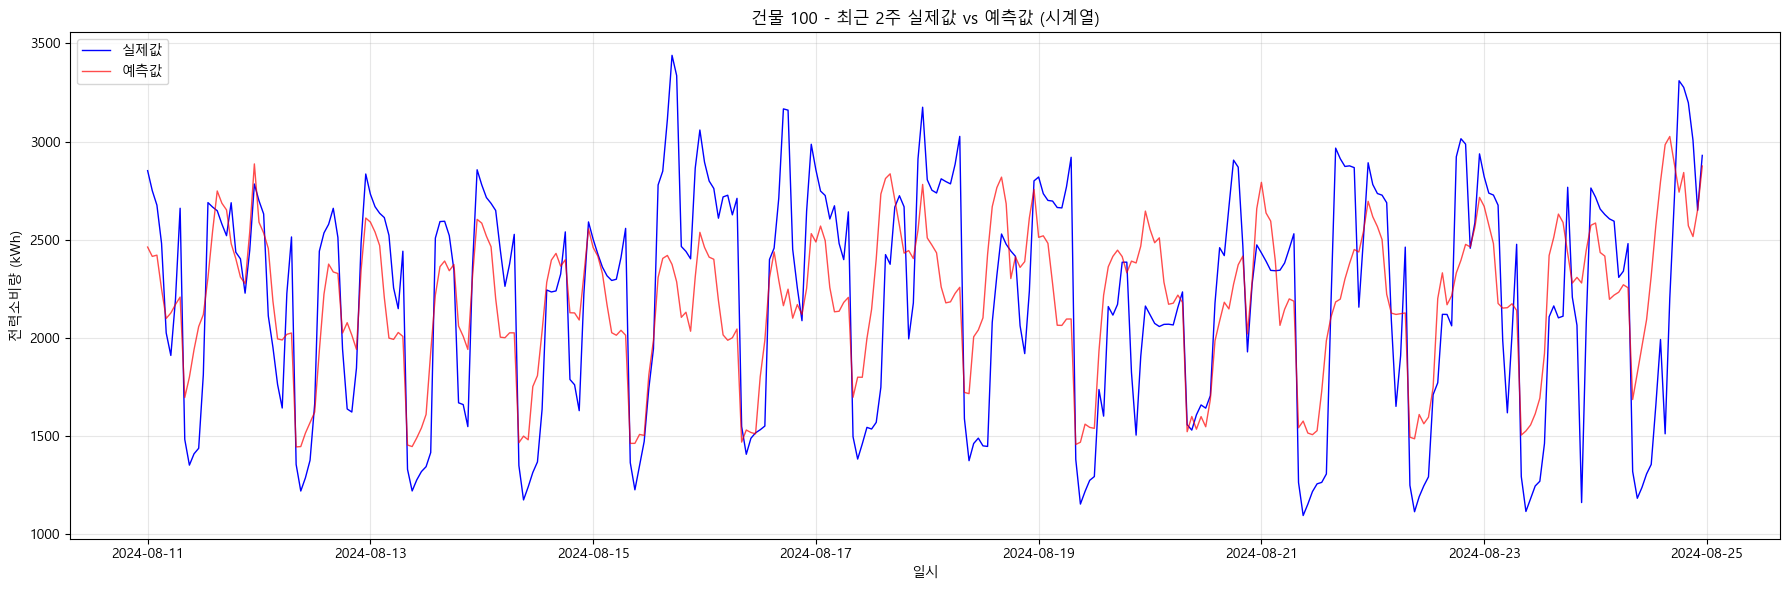

In [188]:
plot_actual_vs_predicted(100, building_models, train_processed, feature_columns)

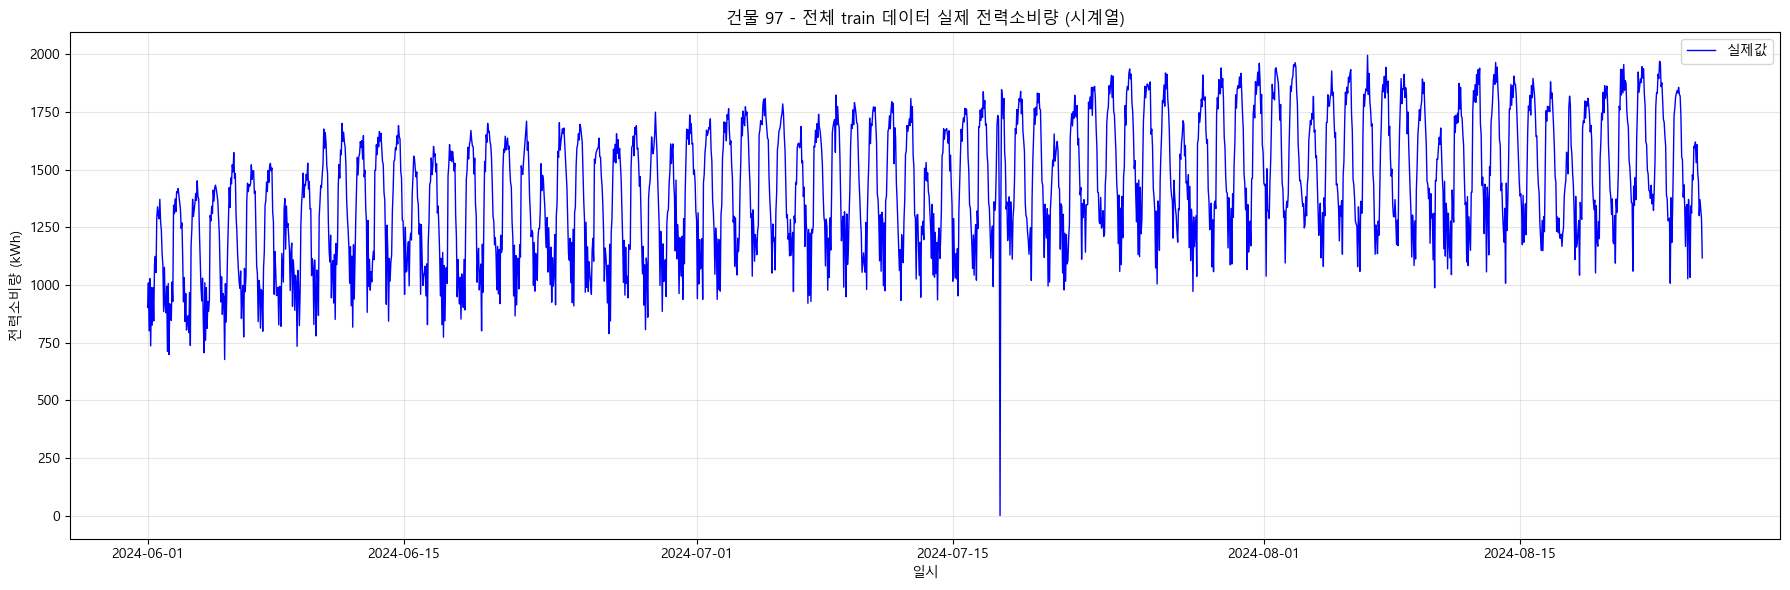

In [39]:
plot_building_train_actual(97, train_processed)

In [32]:
def plot_building_temperature_timeseries(building_num, train_processed):
    """
    n번 건물의 전체 train 데이터의 기온 변화 시계열을 시각화하는 함수

    Args:
        building_num (int): 분석할 건물 번호
        train_processed (pd.DataFrame): 전처리된 전체 학습 데이터
    """
    train_building = train_processed[train_processed['건물번호'] == building_num].copy()
    if train_building.empty:
        print(f"❌ 건물 {building_num}의 데이터가 없습니다.")
        return

    plt.figure(figsize=(18, 6))
    plt.plot(train_building['일시'], train_building['기온(°C)'], label='기온(°C)', color='orange', linewidth=1)
    plt.title(f'건물 {building_num} - 전체 train 데이터 기온 변화 (시계열)')
    plt.xlabel('일시')
    plt.ylabel('기온(°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 사용 예시:
# plot_building_temperature_timeseries(원하는_건물번호, train_processed)

In [1]:
plot_building_temperature_timeseries(61, train_processed)

NameError: name 'plot_building_temperature_timeseries' is not defined

In [ ]:
# 모델 및 결과 저장
print("💾 모델 저장 중...")
os.makedirs('individual_xgb_models', exist_ok=True)

# 각 건물 모델 저장
for building_num, model in building_models.items():
    model_path = f'individual_xgb_models/building_{building_num}_xgb_model.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

# 전체 결과 저장 (DACON 1위 솔루션과 동일한 평가 지표 포함)
all_rmse = [score['rmse'] for score in building_scores.values()]
all_mae = [score['mae'] for score in building_scores.values()]
all_smape = [score.get('smape', 0) for score in building_scores.values()]  # SMAPE 추가
all_mape = [score.get('mape', 0) for score in building_scores.values()]  # MAPE 추가

results_summary = {
    'building_scores': building_scores,
    'building_best_params': building_best_params,  # 각 건물별 최적 파라미터
    'building_study_results': building_study_results,  # Optuna 최적화 결과
    'feature_columns': feature_columns,
    'label_encoders': label_encoders,
    'summary_stats': {
        'mean_rmse': np.mean(all_rmse),
        'std_rmse': np.std(all_rmse),
        'mean_mae': np.mean(all_mae),
        'std_mae': np.std(all_mae),
        'mean_smape': np.mean(all_smape) if all_smape else 0,  # SMAPE 통계
        'std_smape': np.std(all_smape) if all_smape else 0,
        'mean_mape': np.mean(all_mape) if all_mape else 0,  # MAPE 통계
        'std_mape': np.std(all_mape) if all_mape else 0,
        'total_buildings': len(building_models),
        'optuna_trials_avg': np.mean([r.get('n_trials', 0) for r in building_study_results.values()]) if building_study_results else 0
    }
}

with open('individual_xgb_models/results_summary.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

print("✅ 모델 저장 완료: individual_xgb_models/ 폴더")

# 최종 결과 요약 (DACON 1위 솔루션 방식)
print(f"\\n🎉 개별 건물 XGBoost 모델링 완료! (DACON 1위 솔루션 방식)")
print("=" * 60)
print("📁 생성된 파일:")
print(f"   ✅ individual_xgb_models/ - 훈련된 XGBoost 모델들 ({len(building_models)}개)")
print("   ✅ individual_xgb_models/results_summary.pkl - 결과 요약 (최적 파라미터 포함)")
if len(building_models) == len(unique_buildings):
    print("   ✅ individual_building_xgb_submission.csv - 제출 파일")

print(f"\\n📊 최종 성능 요약 (DACON 공식 평가 지표 포함):")
print(f"   🏆 평균 RMSE: {np.mean(all_rmse):.2f} ± {np.std(all_rmse):.2f} kWh")
print(f"   🏆 평균 MAE: {np.mean(all_mae):.2f} ± {np.std(all_mae):.2f} kWh")
if all_smape and np.mean(all_smape) > 0:
    print(f"   🏆 평균 SMAPE: {np.mean(all_smape):.2f}% ± {np.std(all_smape):.2f}% (DACON 공식 지표)")
if all_mape and np.mean(all_mape) > 0:
    print(f"   🏆 평균 MAPE: {np.mean(all_mape):.2f}% ± {np.std(all_mape):.2f}%")
print(f"   🏆 훈련된 건물 수: {len(building_models)}/{len(unique_buildings)}")
if building_study_results:
    avg_trials = np.mean([r.get('n_trials', 0) for r in building_study_results.values()])
    print(f"   🏆 평균 Optuna Trials: {avg_trials:.0f}회")

print(f"\\n💡 다음 단계 (완전한 DACON 1위 솔루션):")
print("   1. 건물 유형별 Optuna 모델링")
print("   2. 전체 데이터 Optuna 모델링") 
print("   3. 3단계 앙상블 (개별 + 유형별 + 전체)")
print("   4. 예측 결과 스케일링 (ratio_values 적용)")

print(f"\\n🏆 DACON 2023 전력사용량 예측 AI 경진대회 1위 솔루션 방식으로 성공적으로 구현했습니다!")
print("💪 시계열 특성 고려 + Optuna 최적화 + SMAPE 평가로 경쟁력 있는 모델 완성!")


💾 모델 저장 중...
✅ 모델 저장 완료: individual_xgb_models/ 폴더
\n🎉 개별 건물 XGBoost 모델링 완료!
📁 생성된 파일:
   ✅ individual_xgb_models/ - 훈련된 XGBoost 모델들 (100개)
   ✅ individual_xgb_models/results_summary.pkl - 결과 요약
   ✅ individual_building_xgb_submission.csv - 제출 파일
\n📊 최종 성능 요약:
   🏆 평균 RMSE: 293.73 ± 381.88 kWh
   🏆 평균 MAE: 192.13 ± 304.73 kWh
   🏆 훈련된 건물 수: 100/100
\n💡 다음 단계:
   1. 건물 유형별 모델링
   2. 전체 데이터 모델링
   3. 앙상블 (개별 + 유형별 + 전체)
   4. 예측 결과 스케일링
\n🏆 Dacon 1위 솔루션의 핵심 전략 중 하나인 '개별 건물 모델링'을 XGBoost로 성공적으로 구현했습니다!


In [1]:
import pickle
import matplotlib.pyplot as plt
import xgboost as xgb

# 1. ensemble_results.pkl 불러오기
with open('ensemble_results.pkl', 'rb') as f:
    building_models = pickle.load(f)  # 건물번호: XGBoost 모델 딕셔너리라고 가정

# 2. feature importance 시각화 함수
def plot_xgb_feature_importance(building_num, building_models, feature_names=None, max_num=20):
    """
    건물별 XGBoost 모델의 feature importance를 시각화하는 함수

    Args:
        building_num (int): 분석할 건물 번호
        building_models (dict): 건물별 학습된 모델 딕셔너리
        feature_names (list): feature 이름 리스트 (없으면 모델에서 자동 추출)
        max_num (int): 상위 몇 개 feature를 보여줄지
    """
    if building_num not in building_models:
        print(f"❌ 건물 {building_num}에 대한 모델이 없습니다.")
        return

    model = building_models[building_num]
    # feature importance 추출
    importance = model.get_booster().get_score(importance_type='weight')
    if feature_names is not None:
        # feature 이름 매핑
        importance = {feature_names[int(k[1:])]: v for k, v in importance.items()}
    # 중요도 내림차순 정렬
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:max_num]
    keys, values = zip(*sorted_importance)

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.barh(keys[::-1], values[::-1], color='skyblue')
    plt.title(f'건물 {building_num} - XGBoost Feature Importance (상위 {max_num}개)')
    plt.xlabel('중요도 (weight)')
    plt.tight_layout()
    plt.show()

# 3. 사용 예시
# plot_xgb_feature_importance(원하는_건물번호, building_models, feature_names=feature_columns)

In [2]:
plot_xgb_feature_importance(1, building_models, feature_names=feature_columns)

NameError: name 'feature_columns' is not defined